In [4]:
import os
import sys
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

home = os.path.realpath("..")
data_dir = os.path.join(home, "data")


In [6]:
import importlib as imt
import datasets_v3 as ds3
import datasets_v0 as ds0
import catalog
import utils
import frame_autoencoder as fr

imt.reload(ds3)
imt.reload(ds0)
imt.reload(catalog)
imt.reload(utils) 
imt.reload(fr)

<module 'frame_autoencoder' from '/home/jaejun/Dropbox/dsi/capstone/amzbinimg/src/frame_autoencoder.py'>

In [7]:
import datetime as dt
import tensorflow as tf

import skimage
from skimage.io import imread
from skimage.io import imsave
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model

from tensorflow.keras.layers import Activation, Dense, Input, InputLayer
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import Reshape, Flatten
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.layers import UpSampling2D, MaxPooling2D

from tensorflow.keras.activations import relu

from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

from tensorflow.keras.callbacks import TensorBoard

## Reconstruction Autoencoder

### load datasets for reconstruction

In [8]:
frame = fr.frame_autoencoder(batch_size = 128, 
                            kernel_size = 3, 
                            latent_dim = 256, 
                            layer_filters = [8, 16, 8]
    )

In [6]:
frame.load_and_condition_dataset_reco()

### Build Encoder and Decoder

In [11]:
frame.load_encoder(build_encoder)
frame.load_decoder(build_decoder)

### Build AutoEncoder and compile

In [13]:
frame.load_model_autoencoder(build_autoencoder)

### Display Model structures

In [14]:
frame.encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 8)       224       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 8)       32        
_________________________________________________________________
tf_op_layer_Relu (TensorFlow multiple                  0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        1168      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 16)        64  

In [15]:
frame.decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 256)]             0         
_________________________________________________________________
dense (Dense)                (None, 2048)              526336    
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 8)         584       
_________________________________________________________________
batch_normalization_3 (Batch (None, 16, 16, 8)         32        
_________________________________________________________________
tf_op_layer_Relu_3 (TensorFl multiple                  0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 32, 32, 8)         0   

In [16]:
frame.autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 128, 128, 3)]     0         
_________________________________________________________________
encoder (Model)              (None, 256)               527224    
_________________________________________________________________
decoder (Model)              (None, 128, 128, 3)       529595    
Total params: 1,056,819
Trainable params: 1,056,563
Non-trainable params: 256
_________________________________________________________________


### Fit Autoencoder for reconstuction of the image

In [17]:
log_dir="../logs/autoencoder_reco/train/" + dt.datetime.now().strftime("%Y%m%d-%H%M%S")
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=0.001)
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)
history = frame.autoencoder.fit(x=frame.Xf_train,
                y=frame.yf_train,
                epochs=40,
                validation_split=0.2,
                batch_size=frame.batch_size,
                callbacks = [tensorboard, callback],
                use_multiprocessing=True
)

Train on 21104 samples, validate on 5276 samples
Epoch 1/40
21104/21104 [==============================] - 38s 2ms/sample - loss: 0.0135 - val_loss: 0.0074
Epoch 2/40
21104/21104 [==============================] - 32s 1ms/sample - loss: 0.0059 - val_loss: 0.0050
Epoch 3/40
21104/21104 [==============================] - 31s 1ms/sample - loss: 0.0047 - val_loss: 0.0044
Epoch 4/40
21104/21104 [==============================] - 31s 1ms/sample - loss: 0.0042 - val_loss: 0.0040
Epoch 5/40
21104/21104 [==============================] - 31s 1ms/sample - loss: 0.0039 - val_loss: 0.0037
Epoch 6/40
21104/21104 [==============================] - 31s 1ms/sample - loss: 0.0037 - val_loss: 0.0035
Epoch 7/40
21104/21104 [==============================] - 31s 1ms/sample - loss: 0.0035 - val_loss: 0.0034
Epoch 8/40
21104/21104 [==============================] - 31s 1ms/sample - loss: 0.0033 - val_loss: 0.0033
Epoch 9/40
21104/21104 [==============================] - 31s 1ms/sample - loss: 0.0032 - val_l

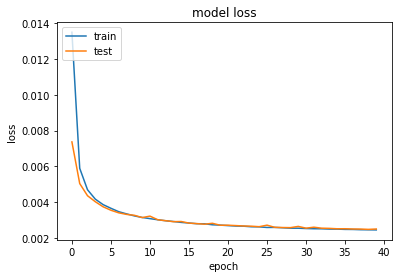

In [19]:
utils.plot_history(history)

### Validate the trained model.

In [20]:
log_dir="../logs/autoencoder/evaluate/" + dt.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)    
frame.autoencoder.evaluate(x=frame.Xf_test, 
                        y=frame.yf_test, 
                        batch_size=frame.batch_size, 
                        verbose=2, 
                        callbacks=[tensorboard], 
                        #max_queue_size=10, 
                        #workers=1, 
                        use_multiprocessing=False
)

2932/1 - 2s - loss: 0.0025


0.002479279444948103

### Save Reconstruction Autoencoder if satisfied

In [21]:
import pickle
with open('../model/history_reco.pkl', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
frame.autoencoder.reset_metrics()
frame.autoencoder.save("../model/autoencoder_reco.h5")
frame.encoder.save("../model/encoder_reco.h5")
frame.decoder.save("../model/decoder_reco.h5")

### Visualize Each Layers of Encoder

encoder_input (1, 128, 128, 3) 


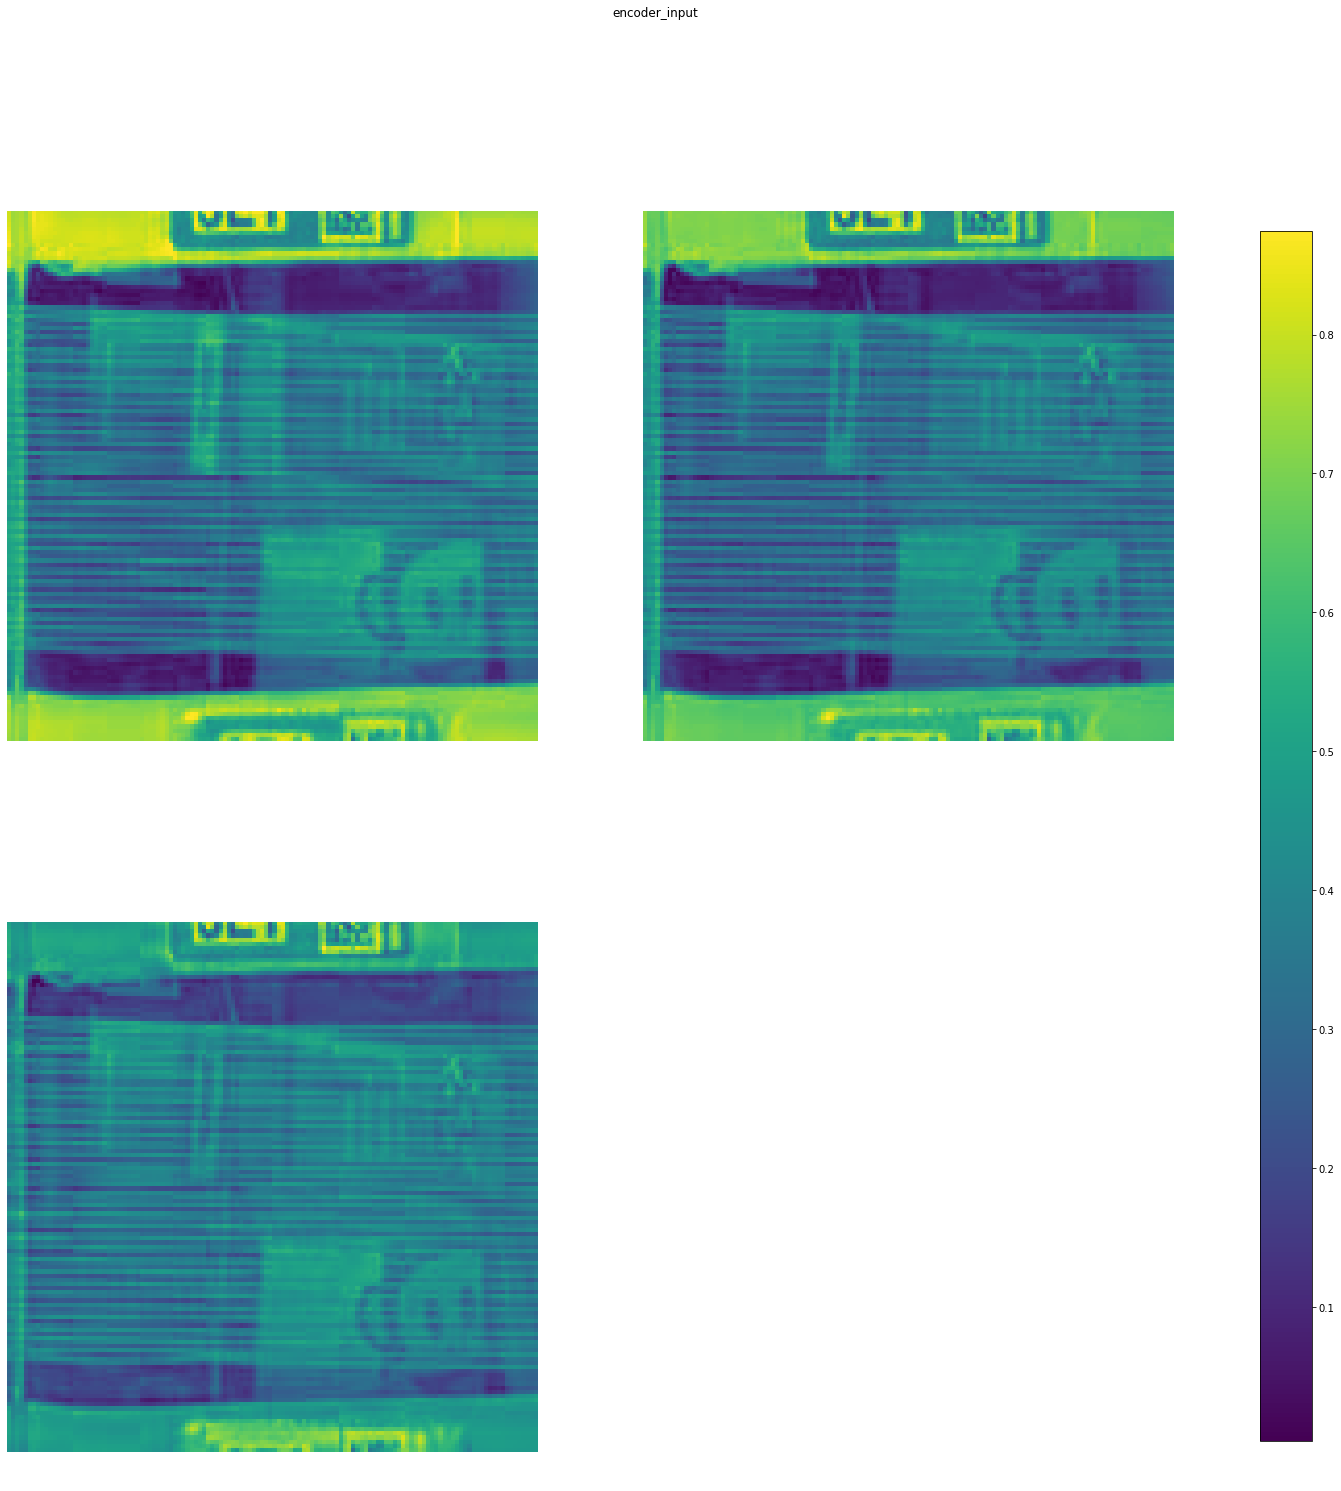

conv2d (1, 128, 128, 8) 


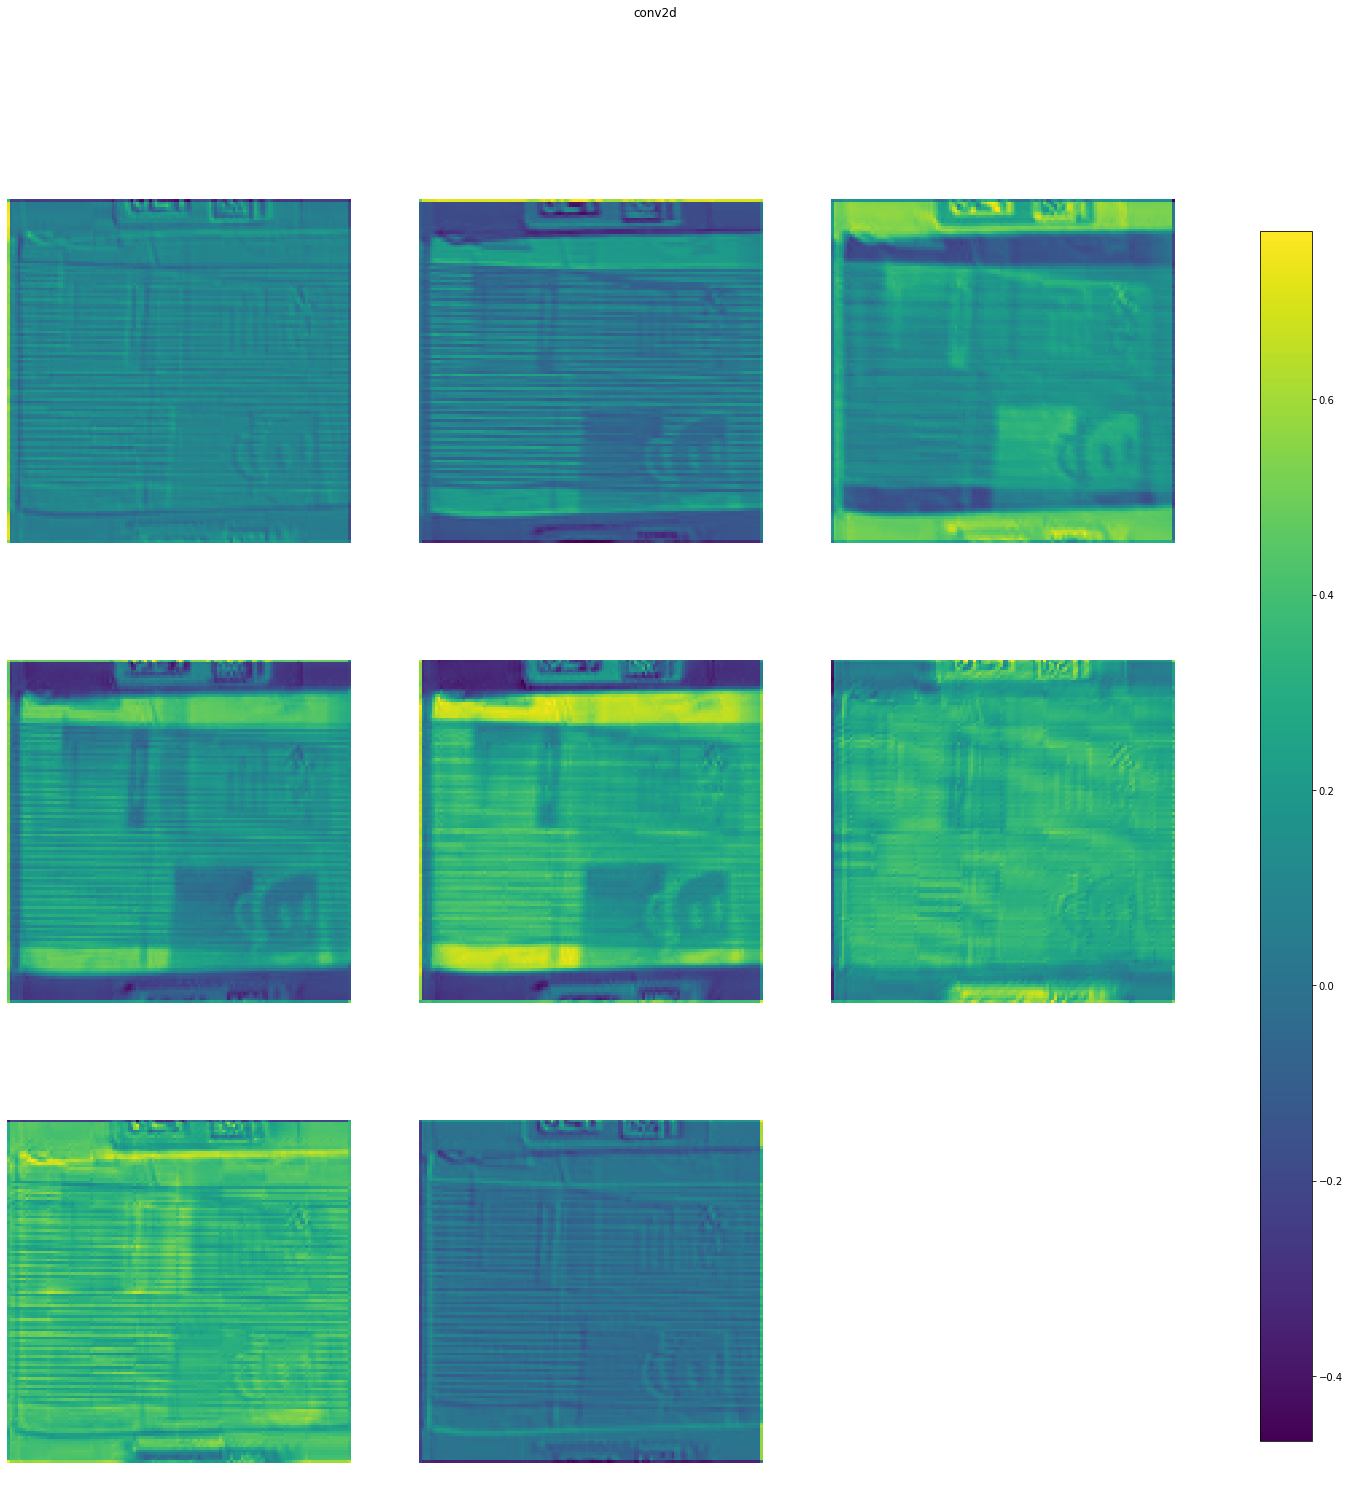

batch_normalization (1, 128, 128, 8) 


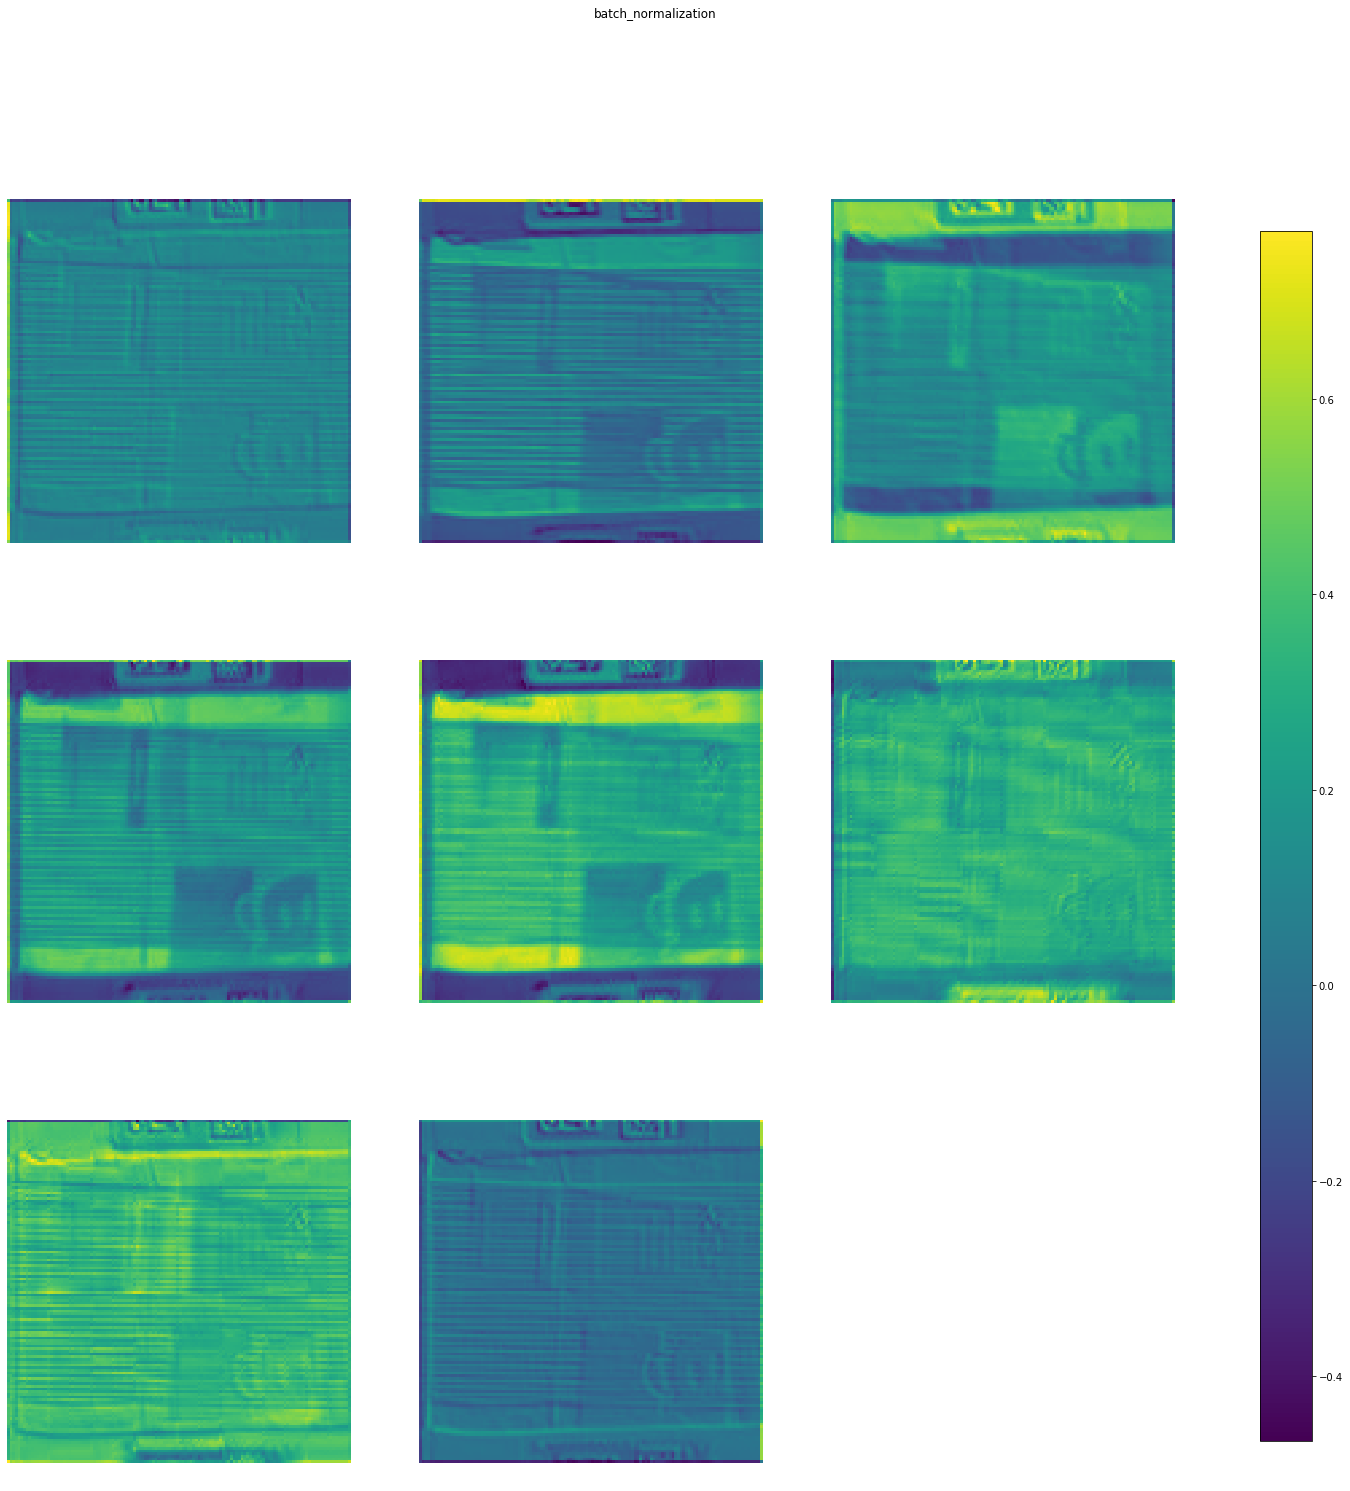

Relu (1, 128, 128, 8) 


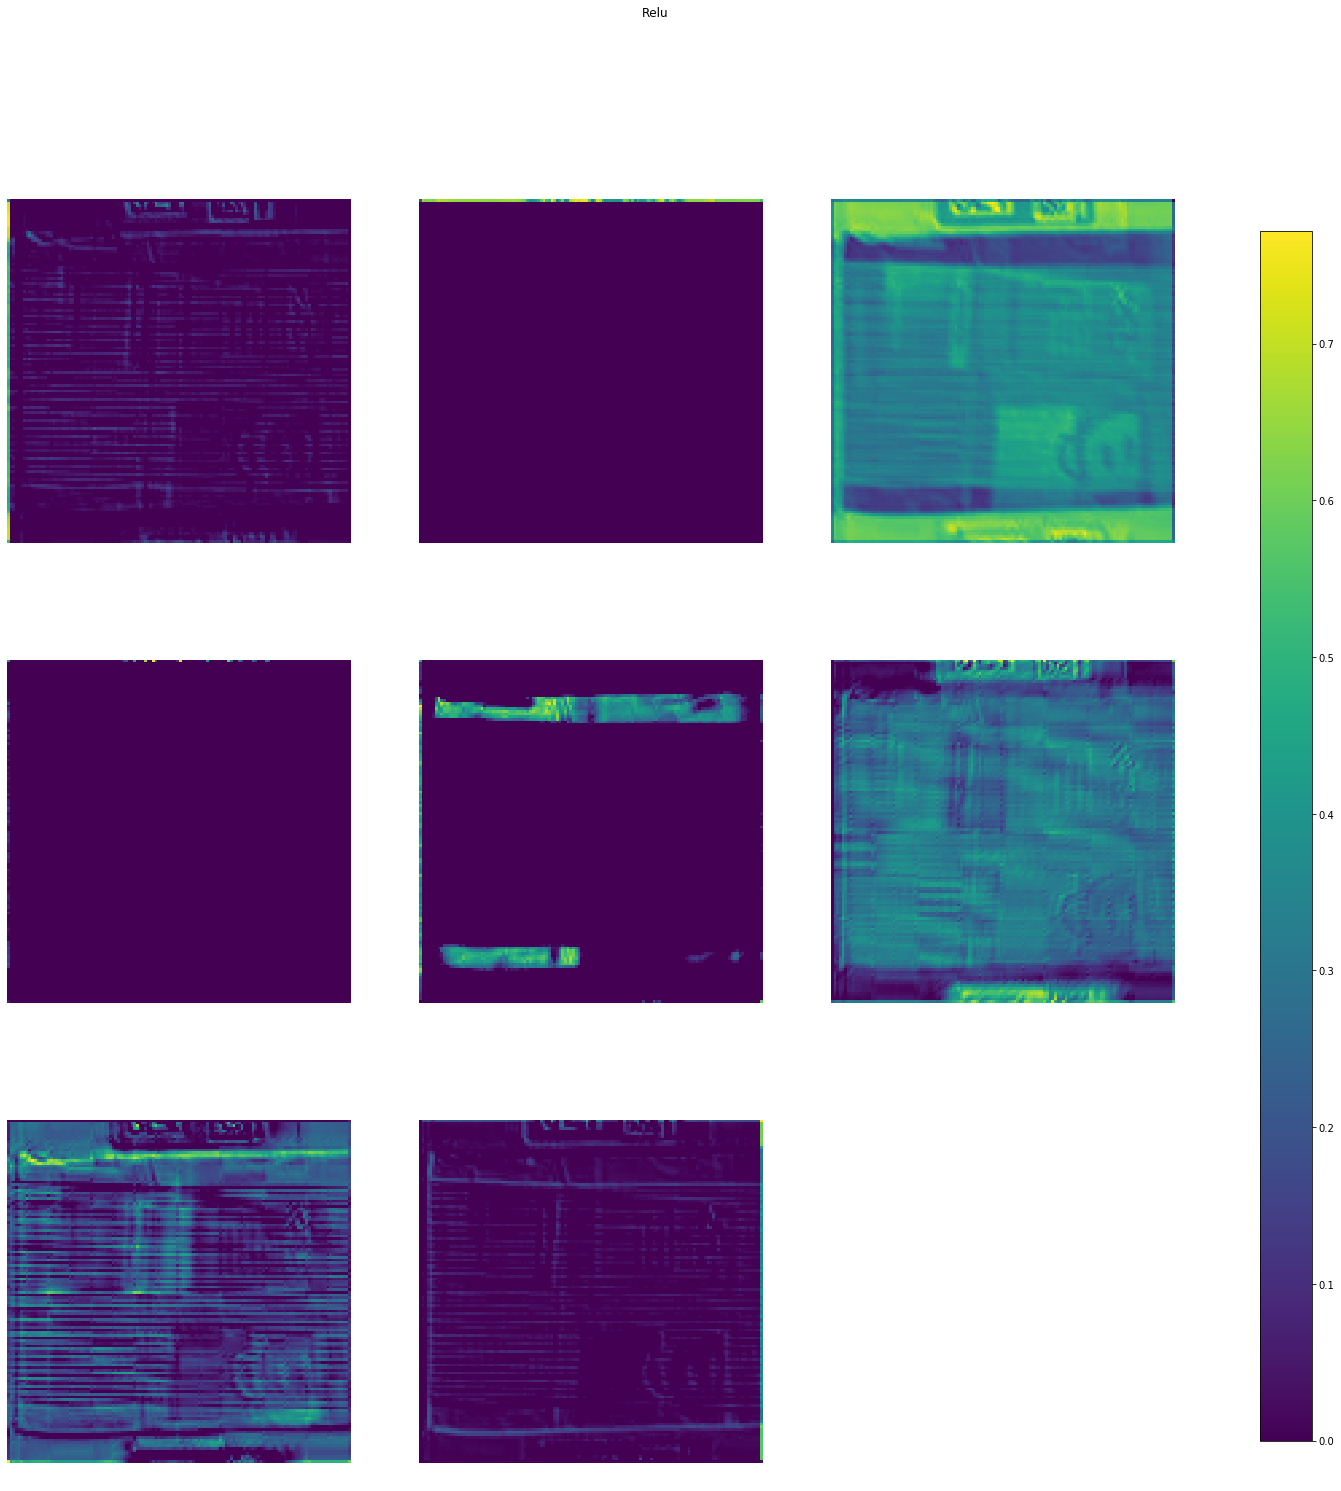

max_pooling2d (1, 64, 64, 8) 


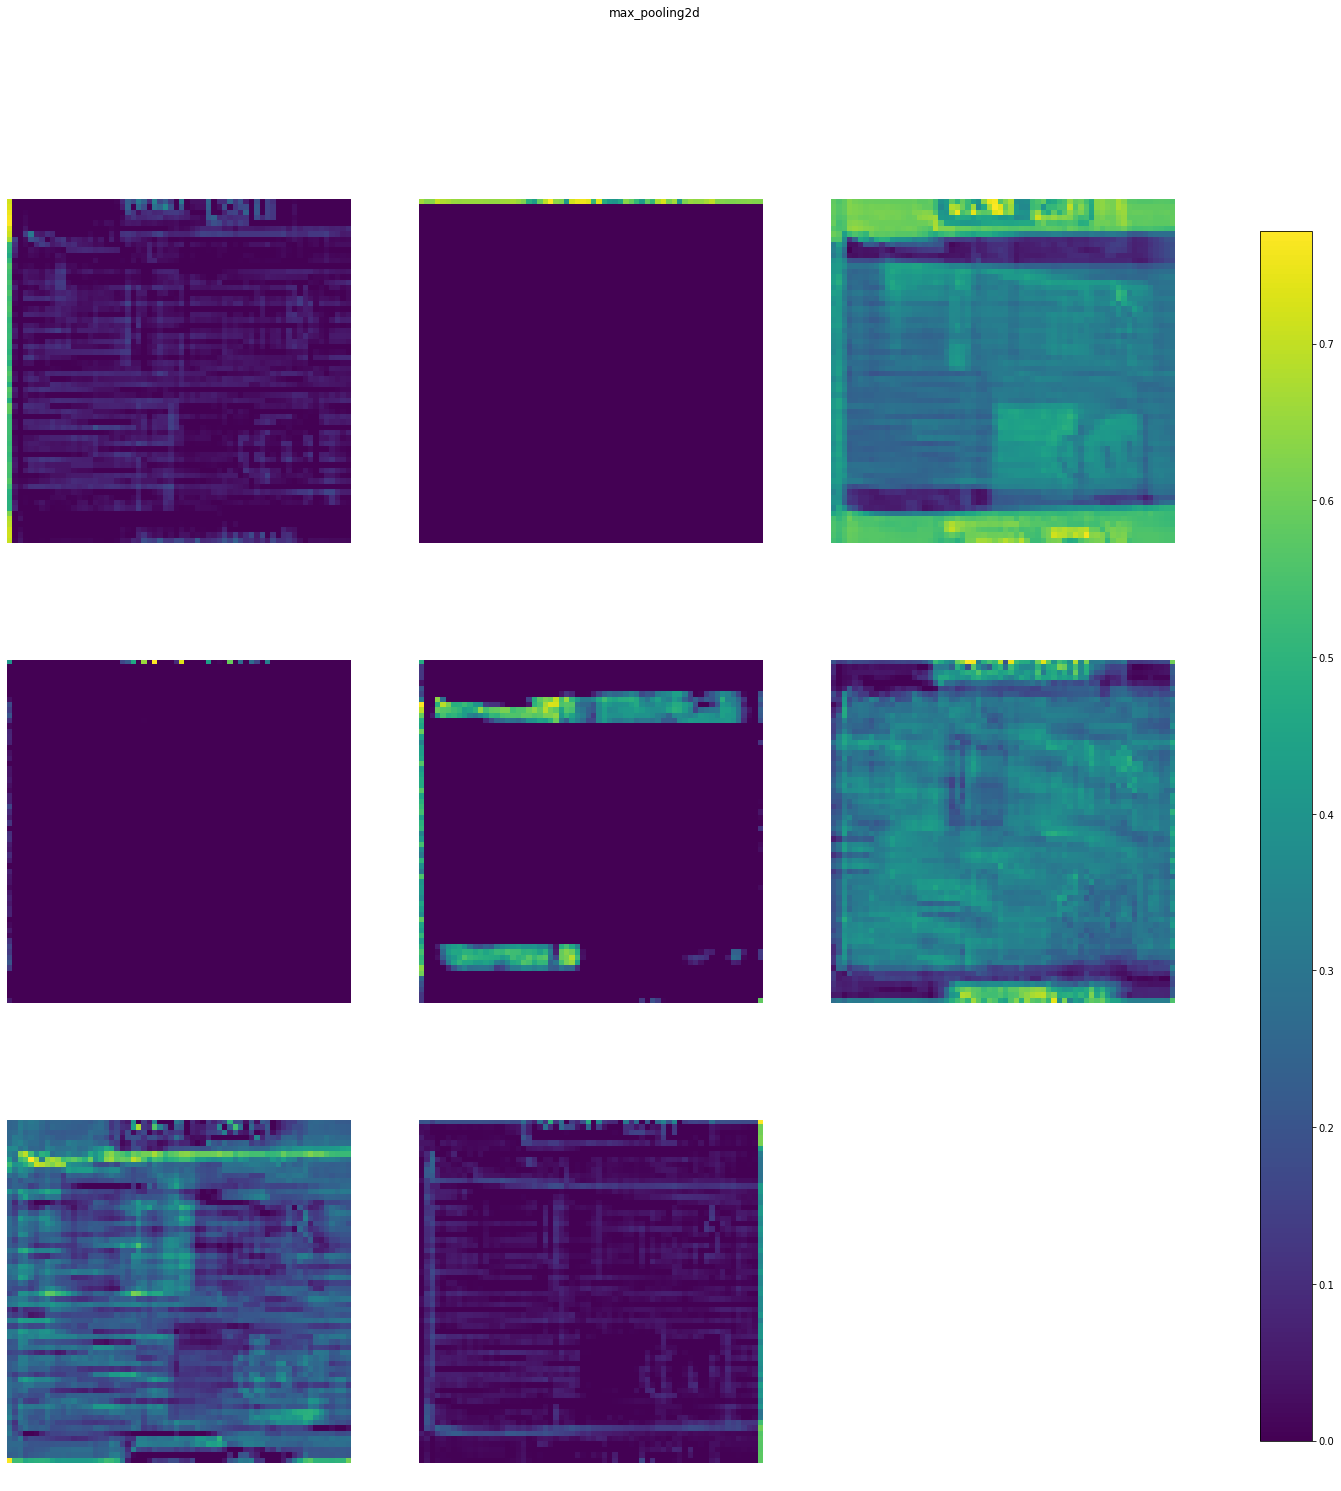

conv2d_1 (1, 64, 64, 16) 


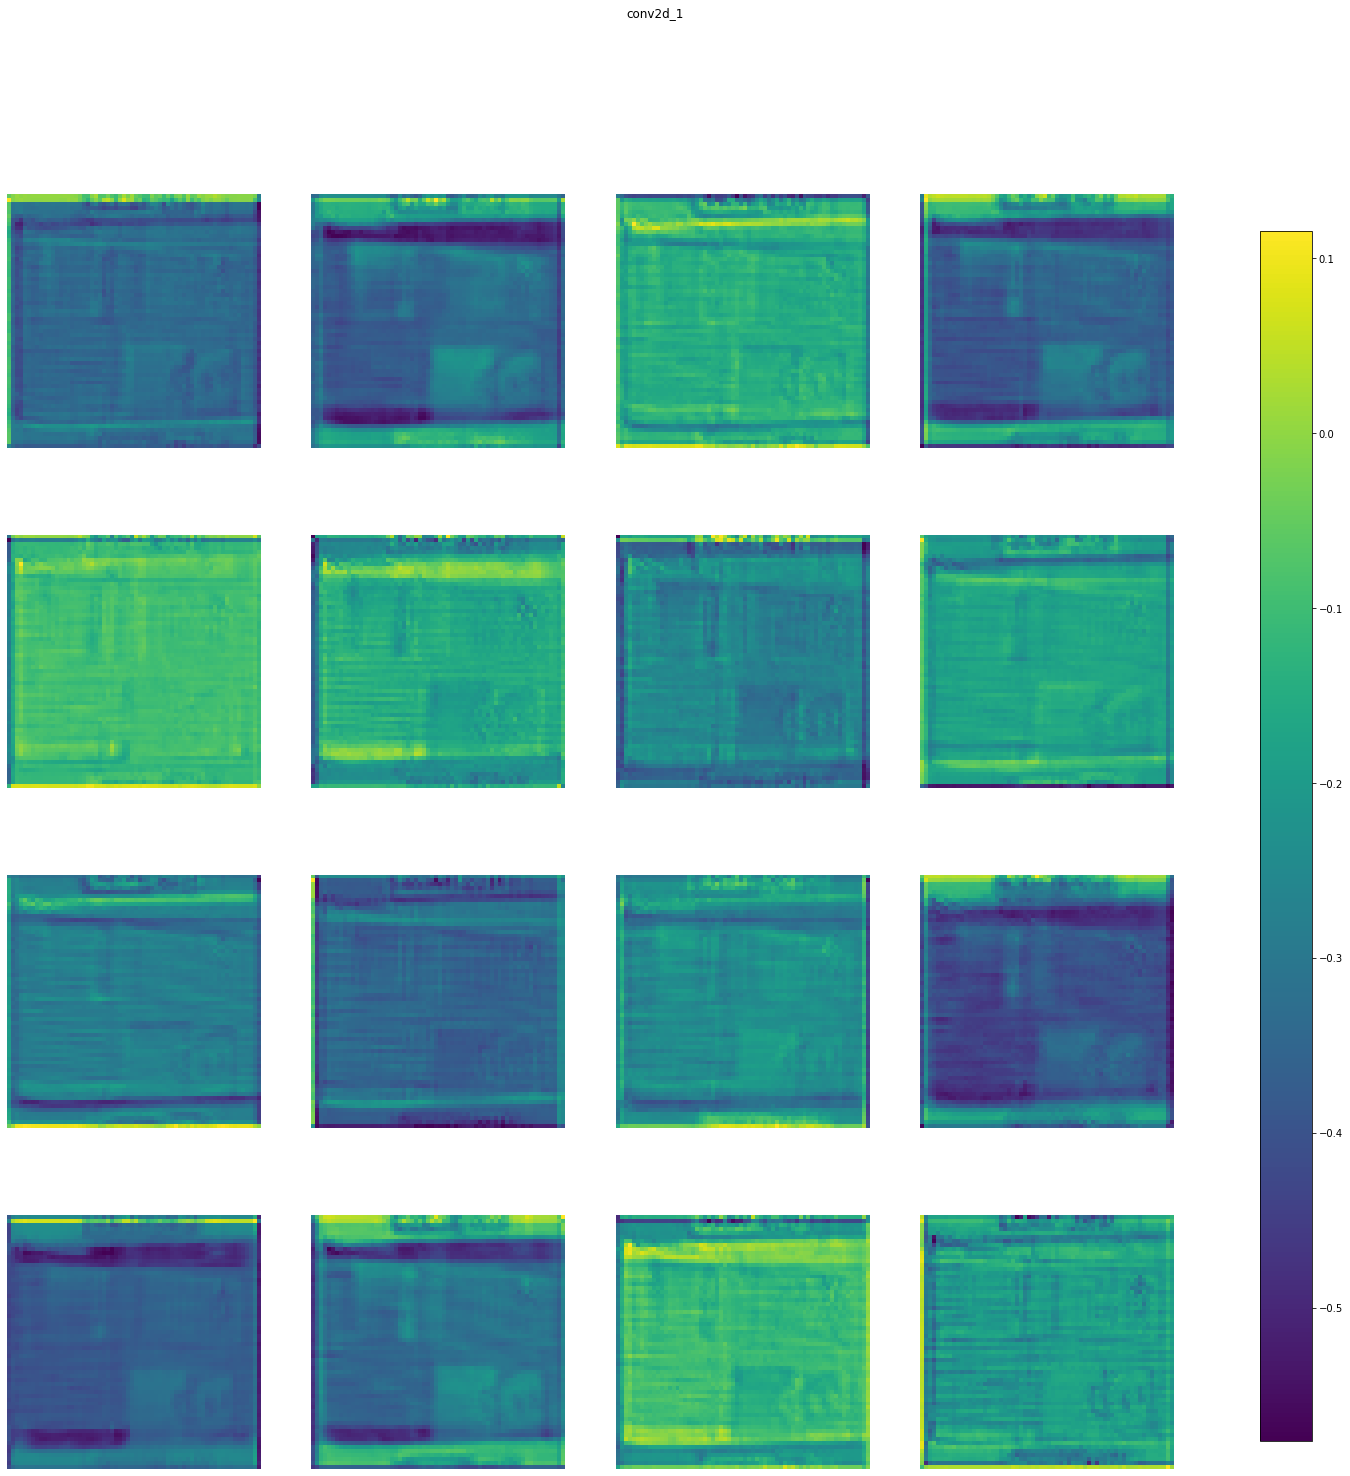

batch_normalization_1 (1, 64, 64, 16) 


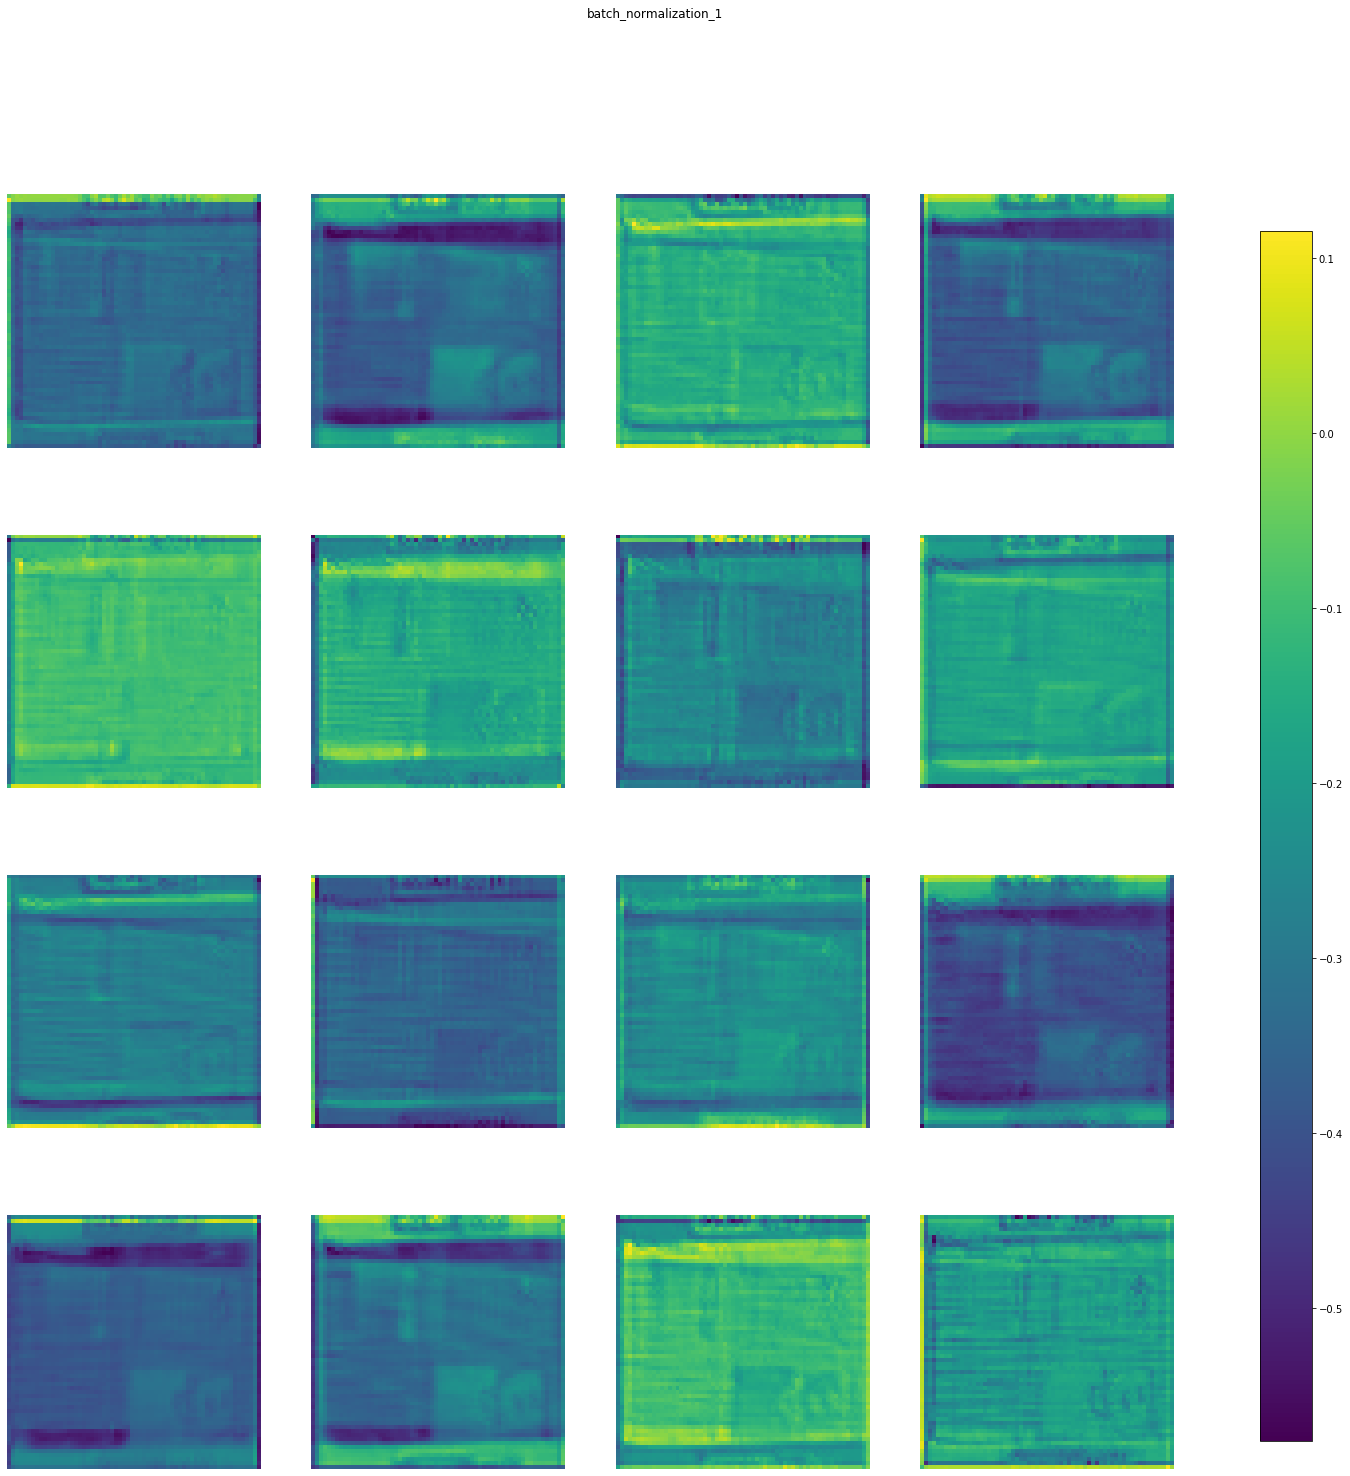

Relu_1 (1, 64, 64, 16) 


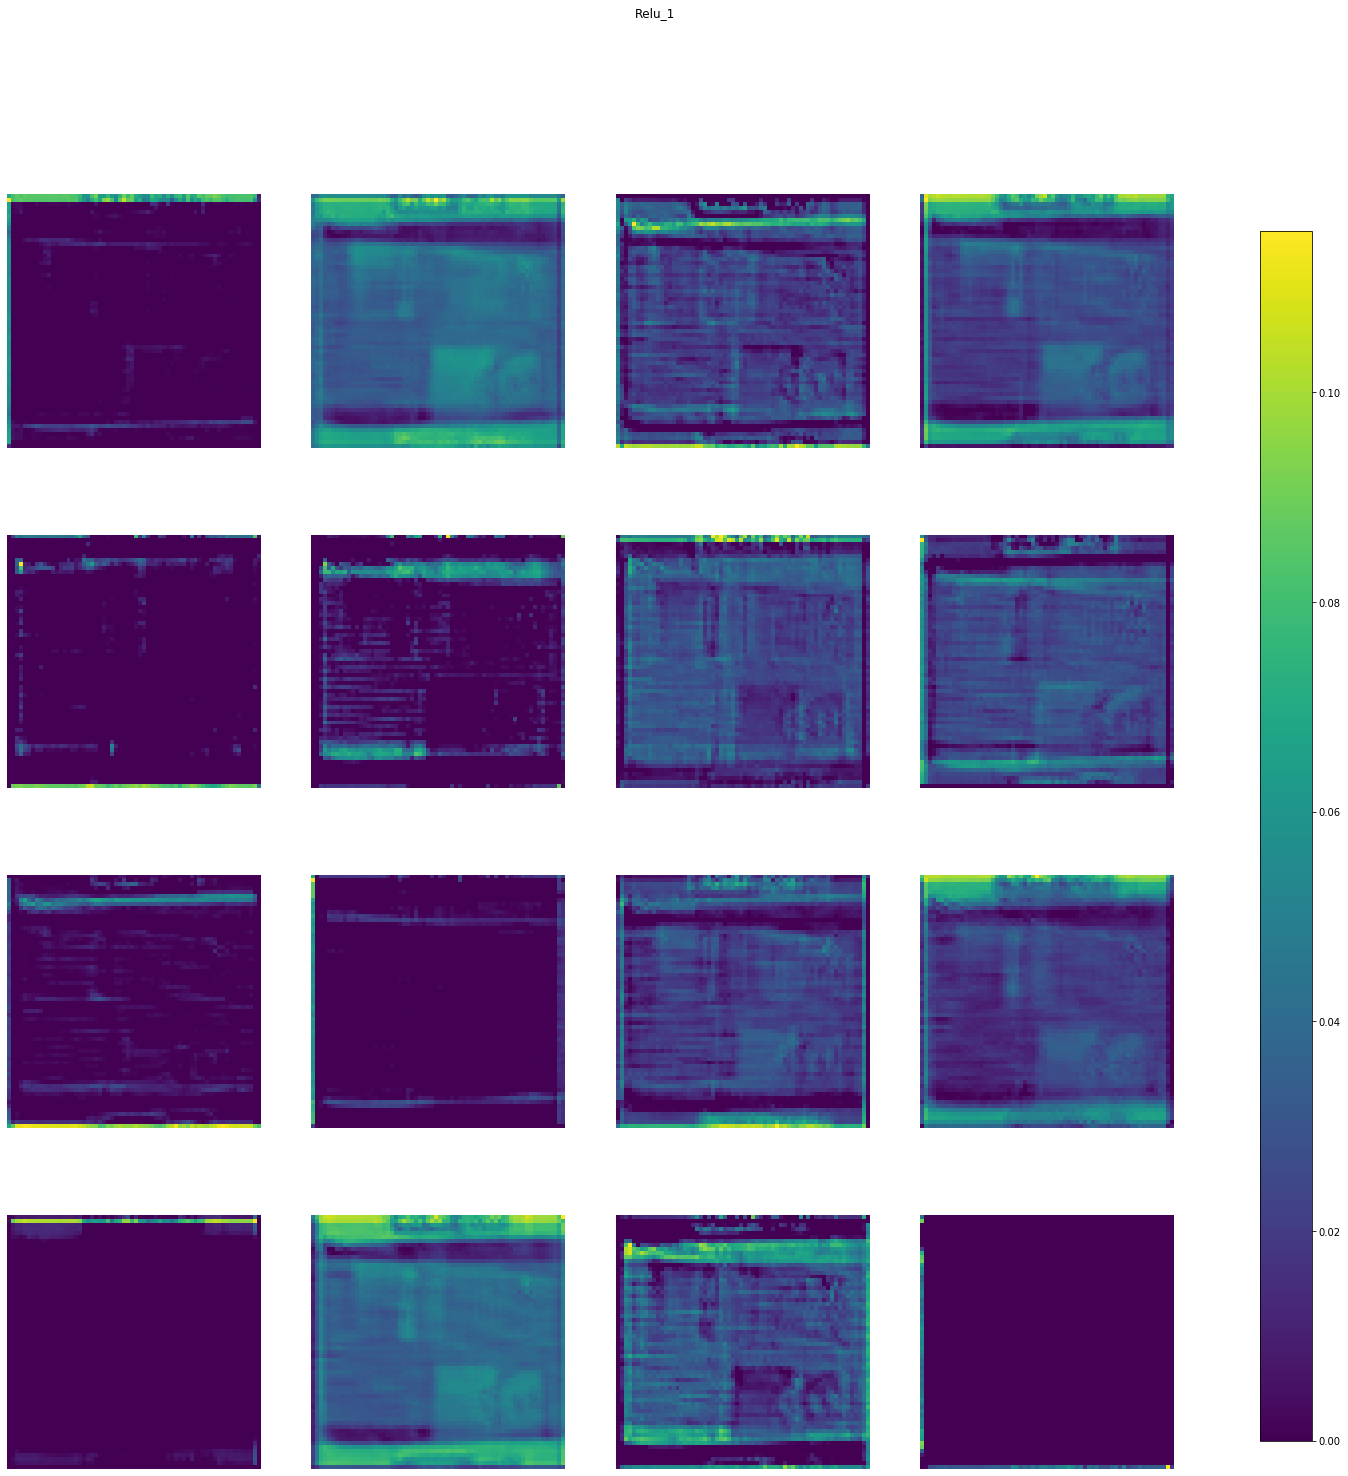

max_pooling2d_1 (1, 32, 32, 16) 


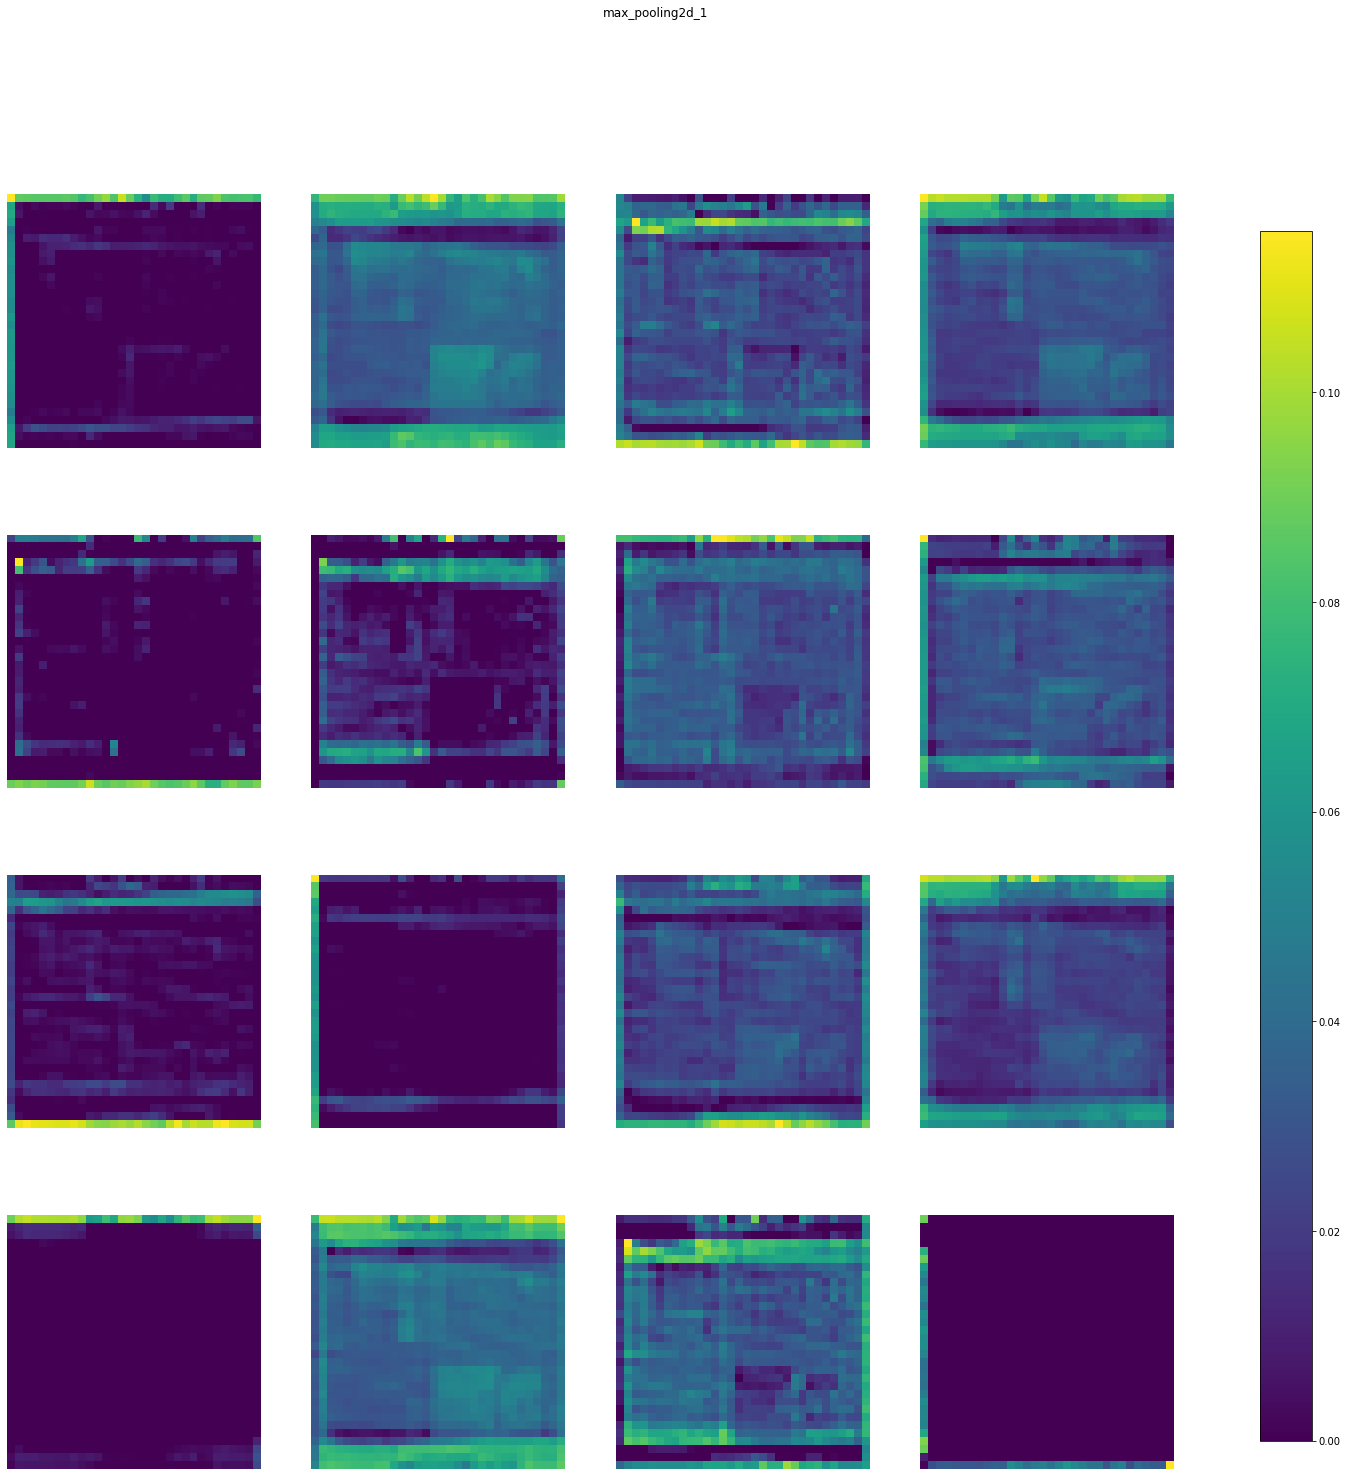

conv2d_2 (1, 32, 32, 8) 


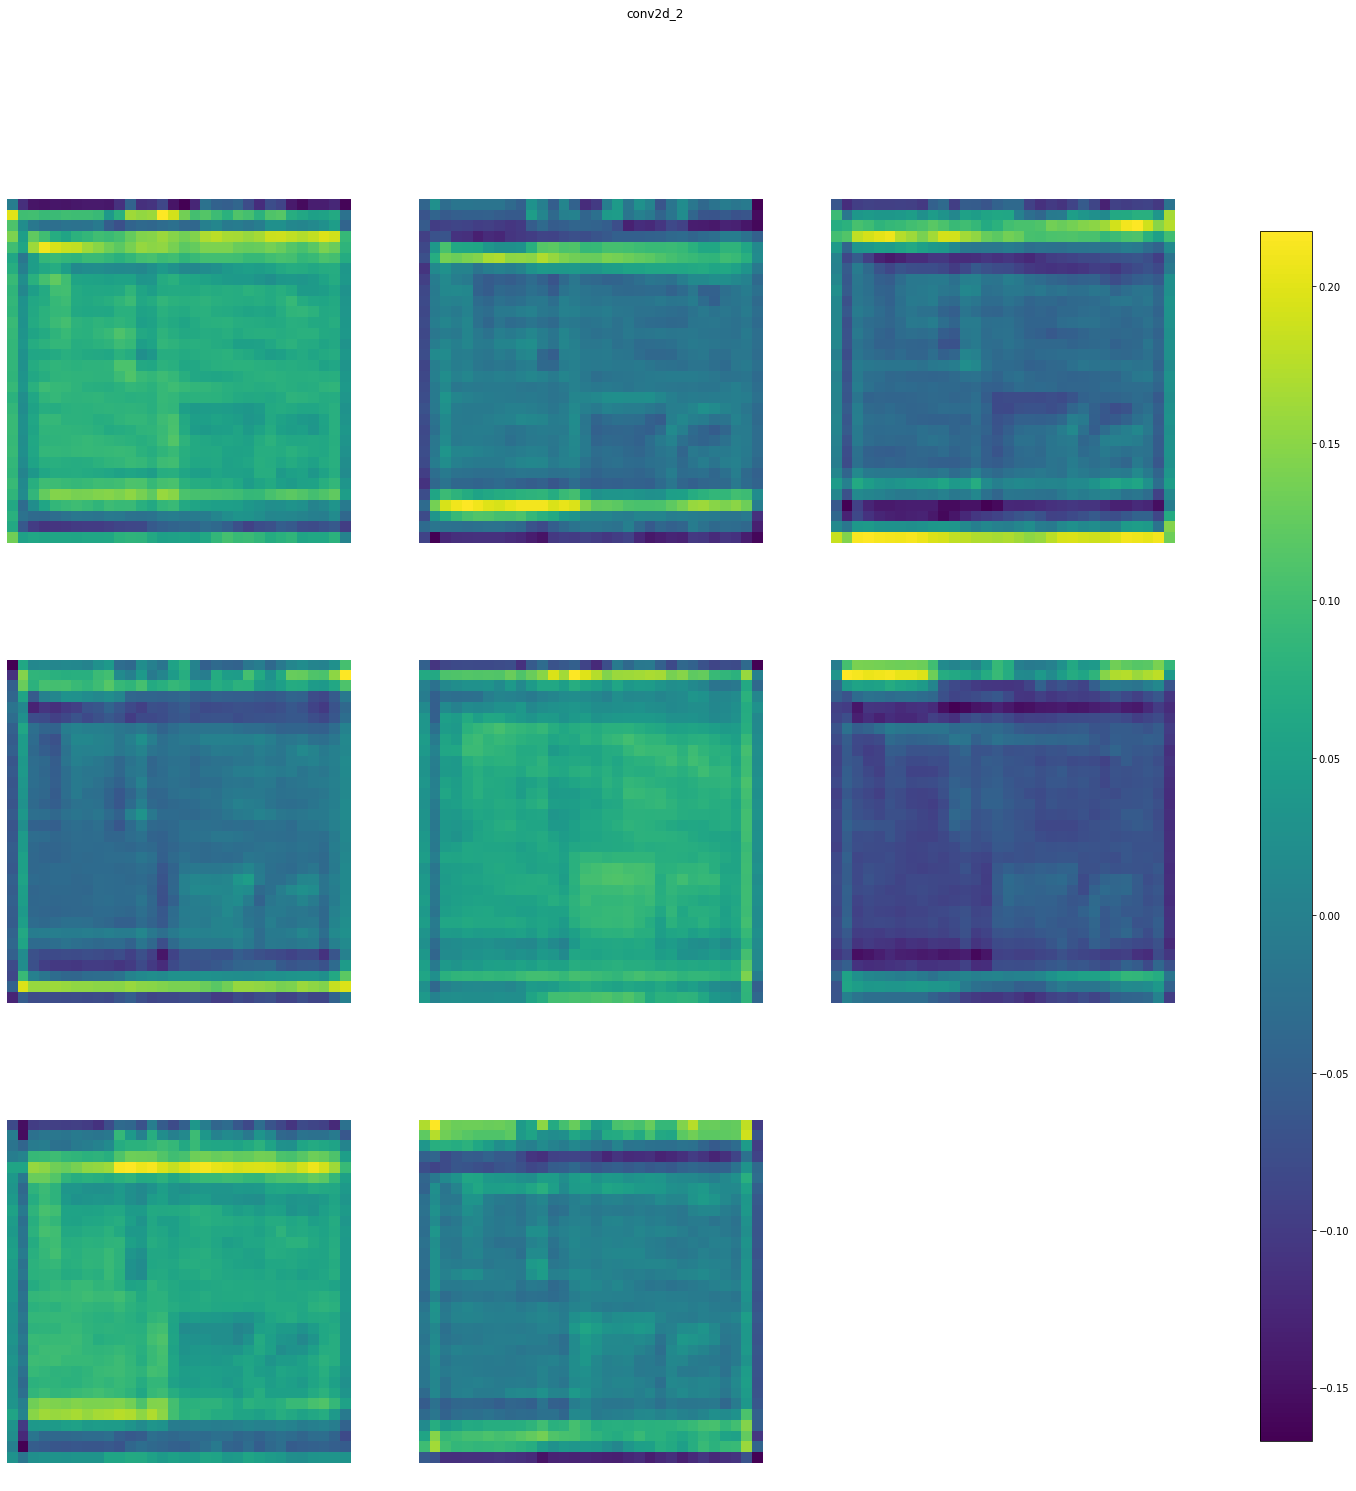

batch_normalization_2 (1, 32, 32, 8) 


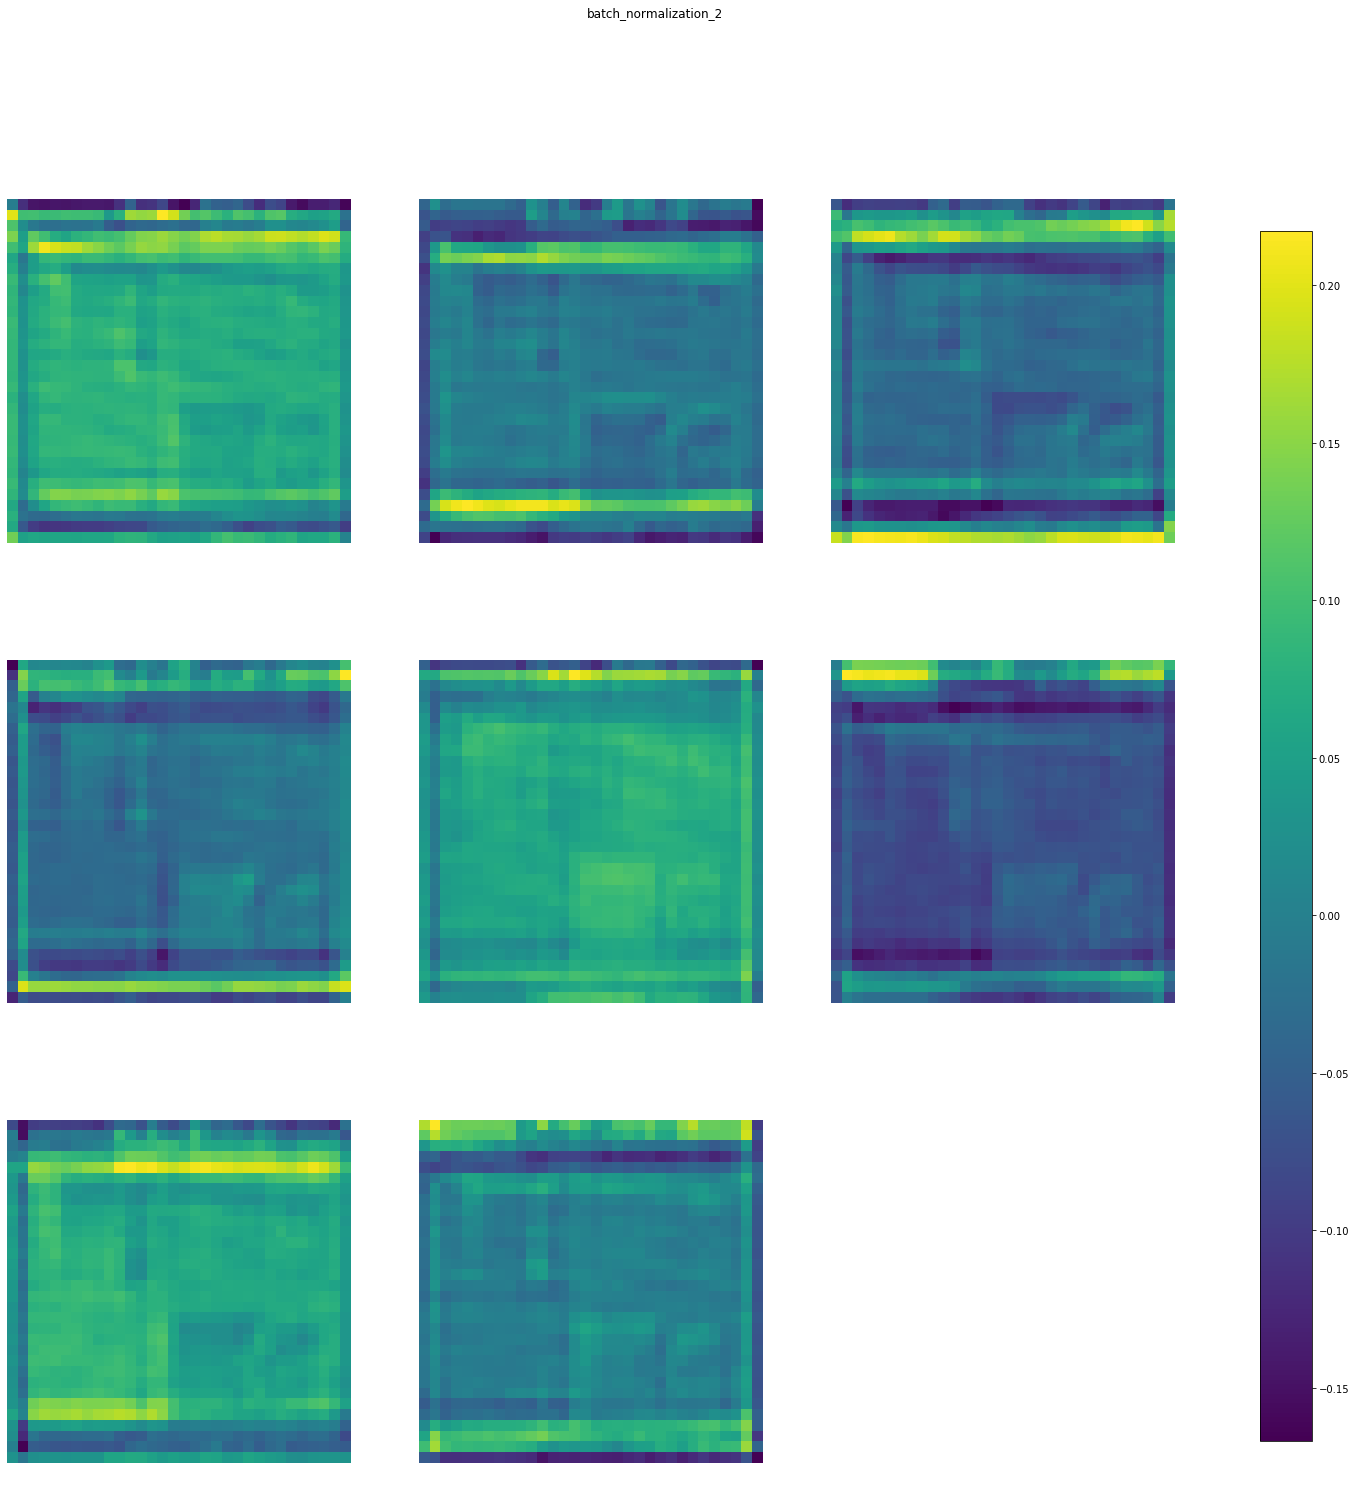

Relu_2 (1, 32, 32, 8) 


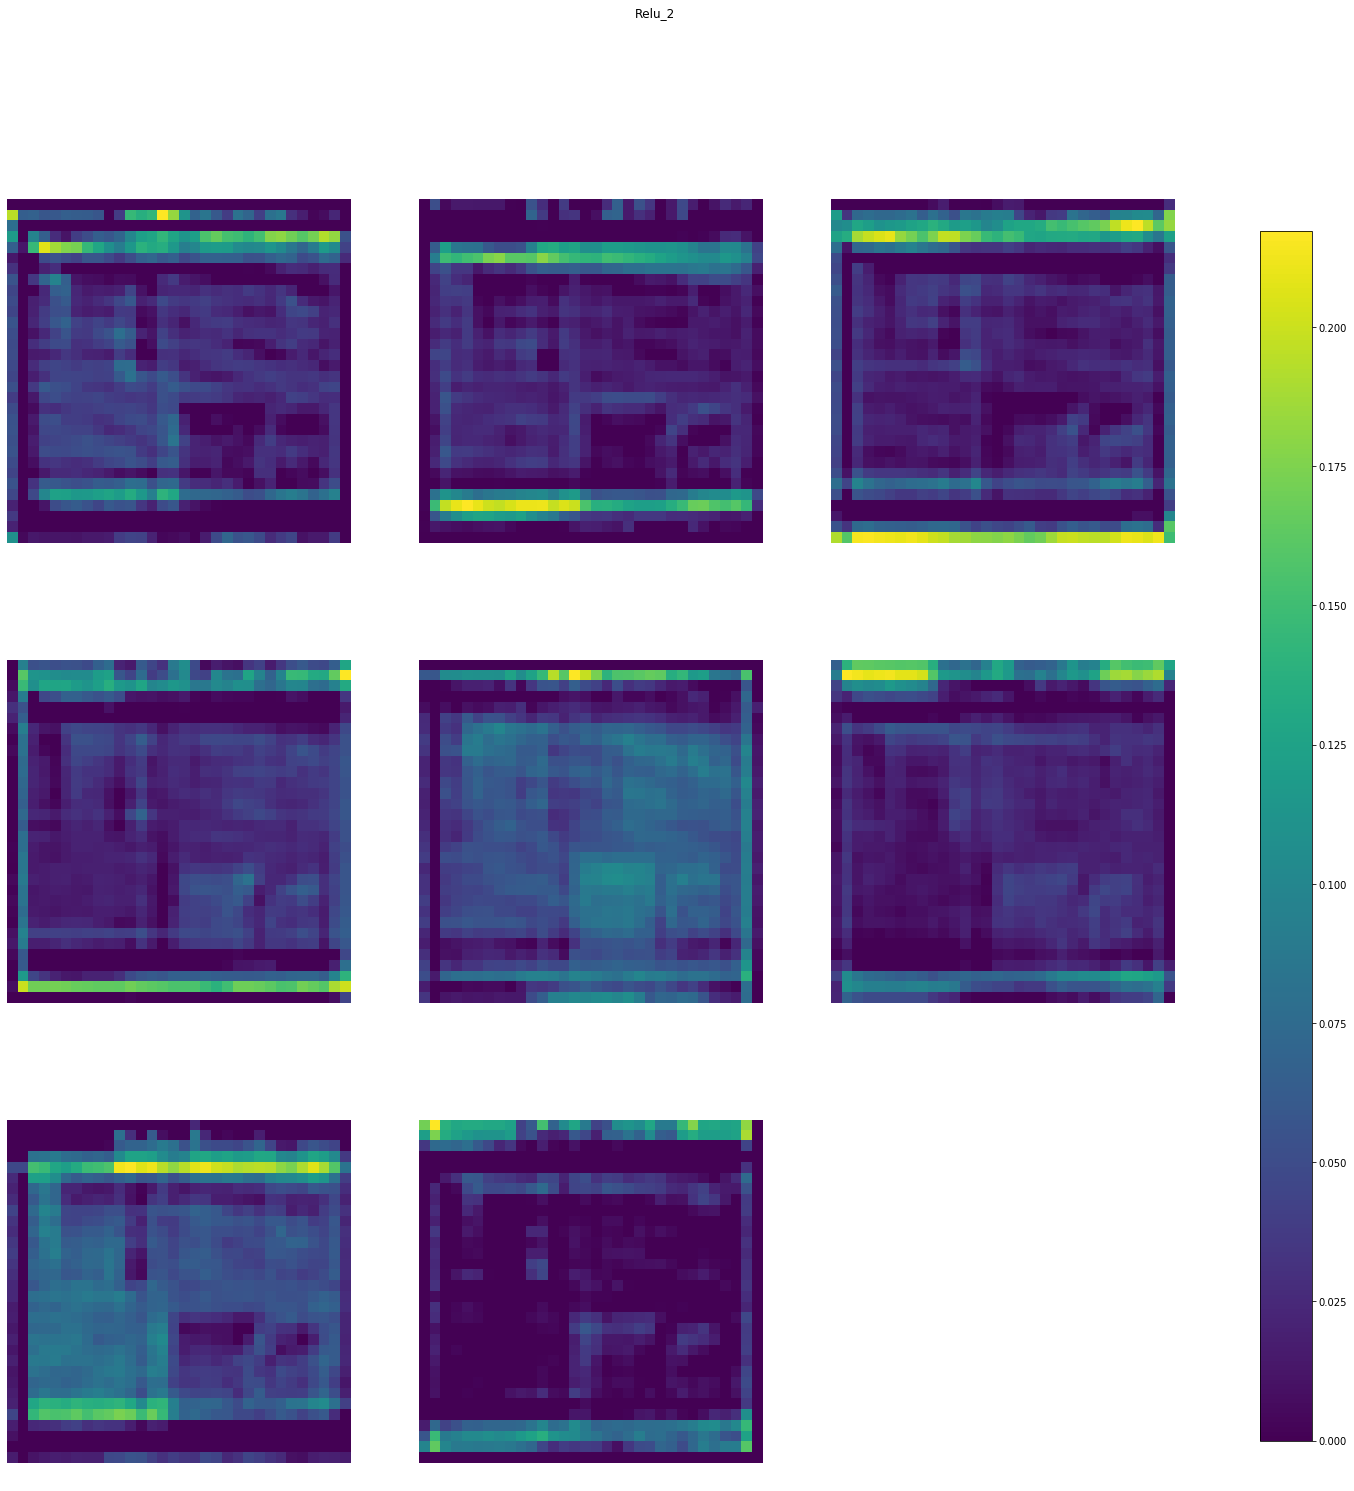

max_pooling2d_2 (1, 16, 16, 8) 


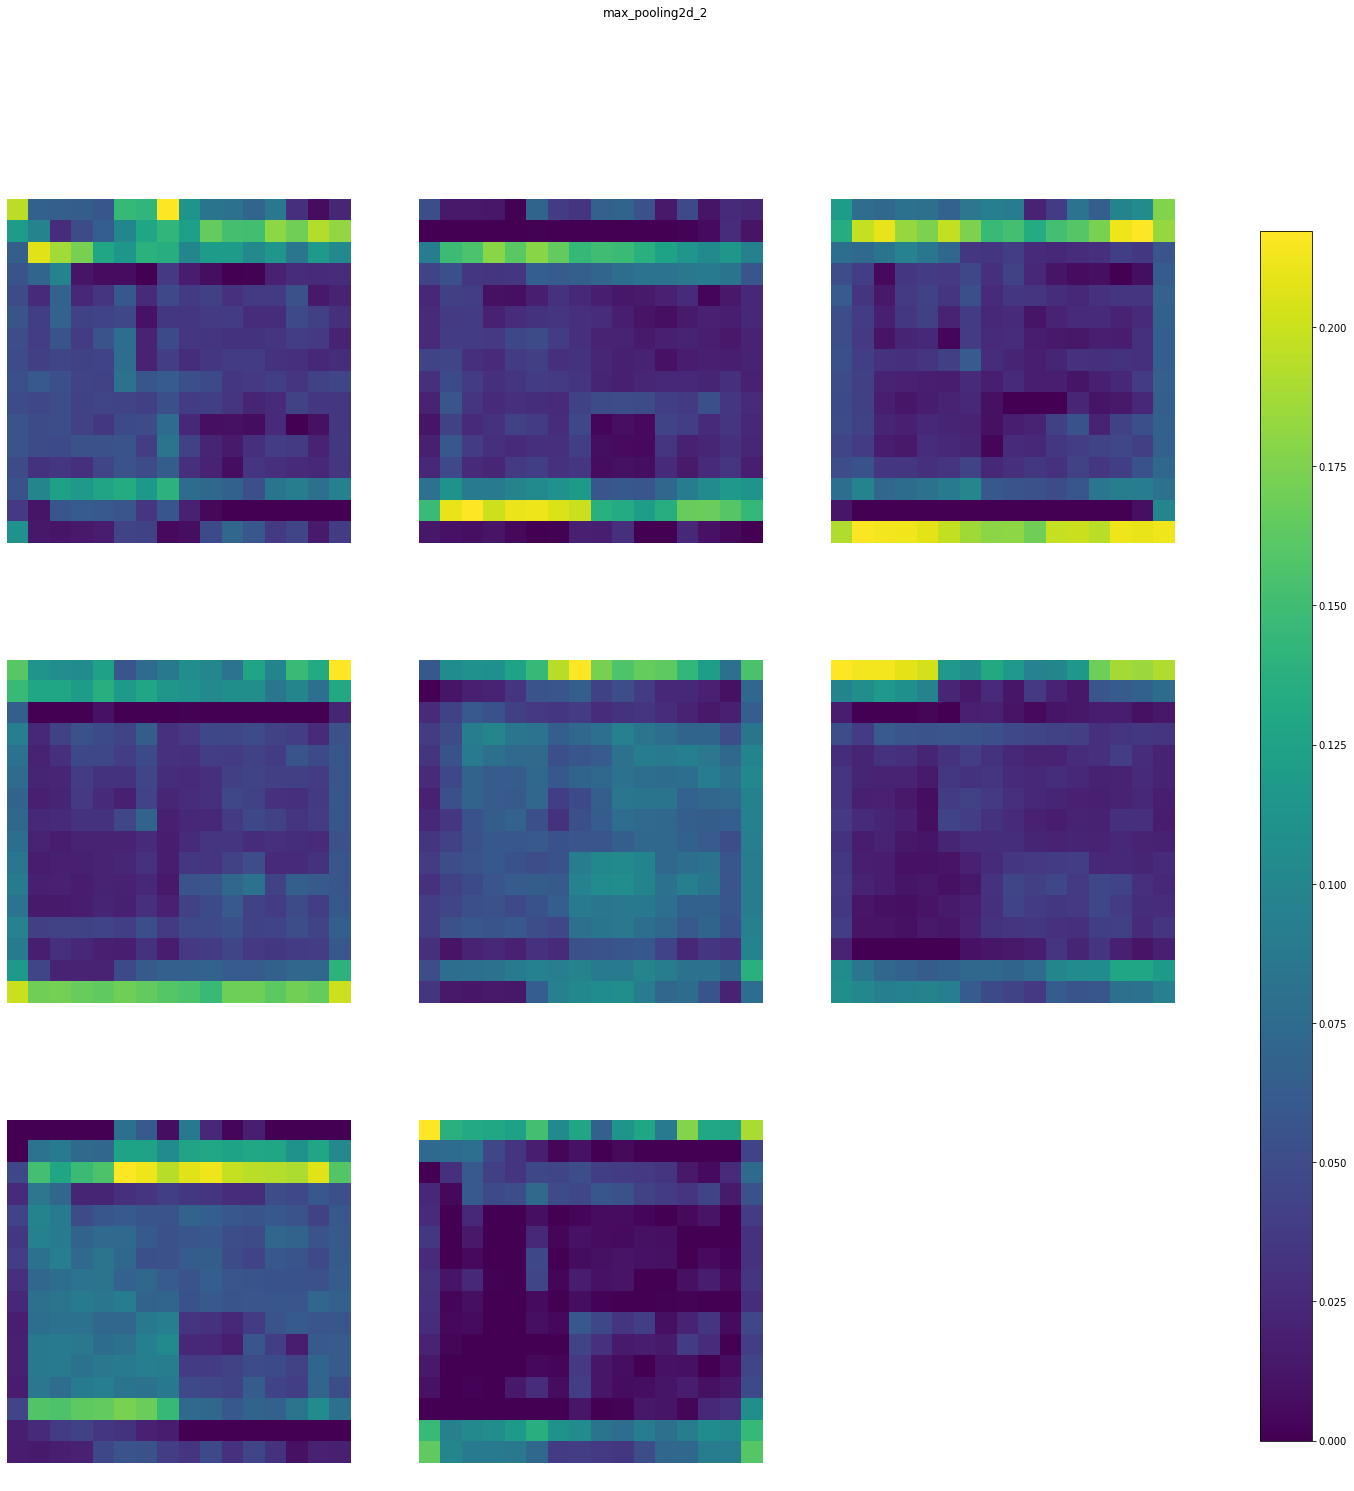

flatten (1, 2048) 


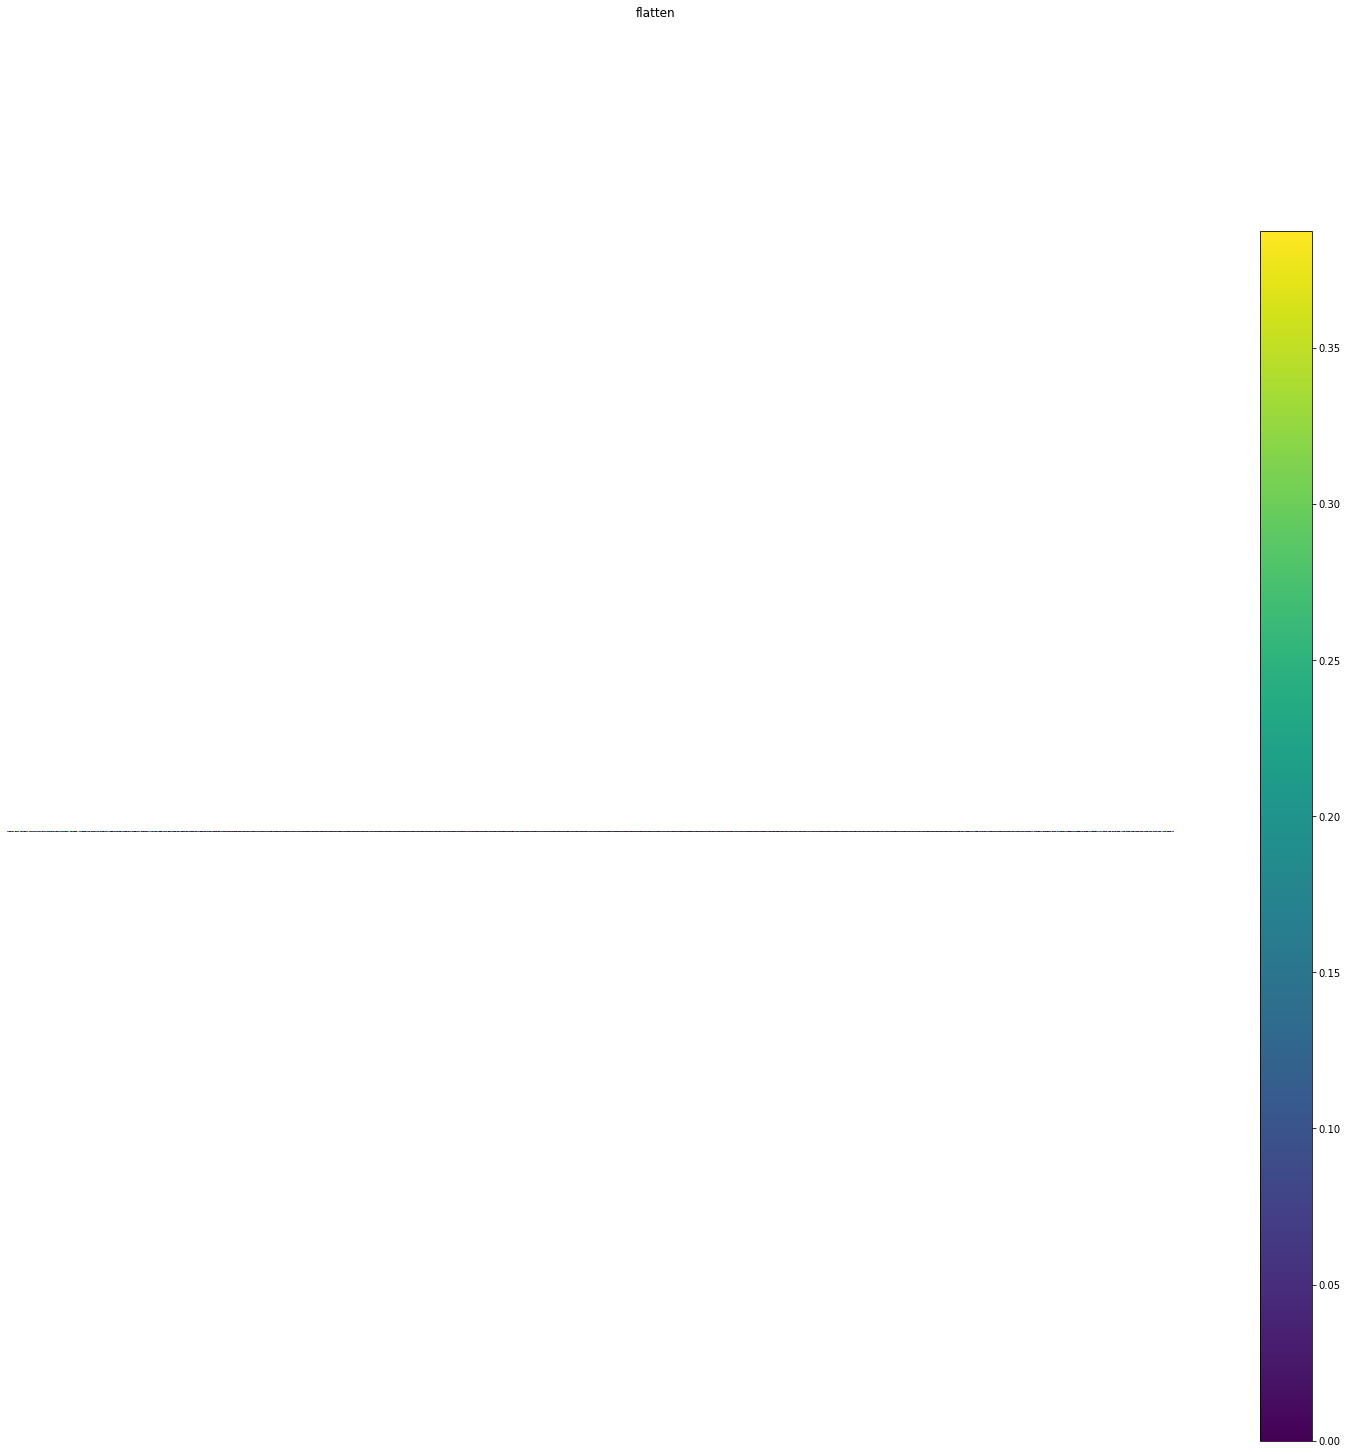

latent_vector (1, 256) 


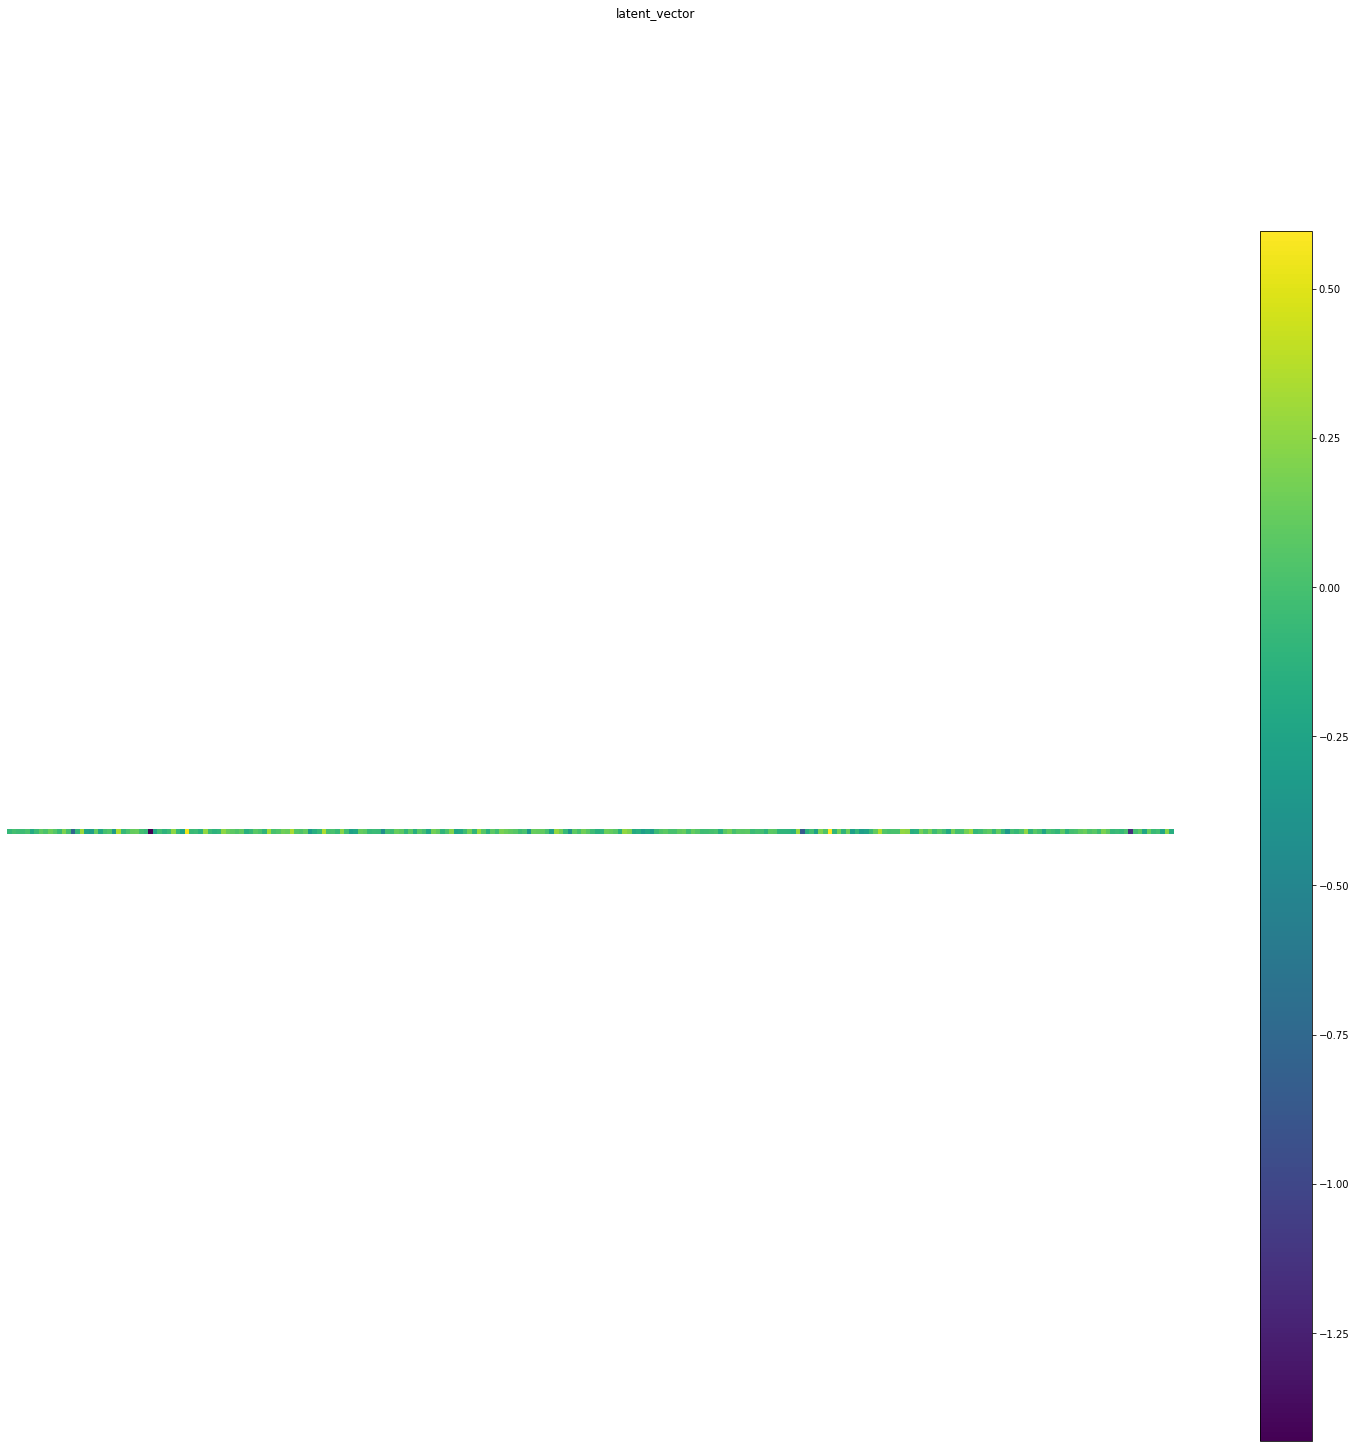

In [45]:
from keract import get_activations
from keract import display_activations
activations = get_activations(frame.encoder, frame.Xf_test[0:1], layer_name=None)
display_activations(activations, cmap='viridis', save=False)

### Visually Check Reconstruction power of Autoencoder

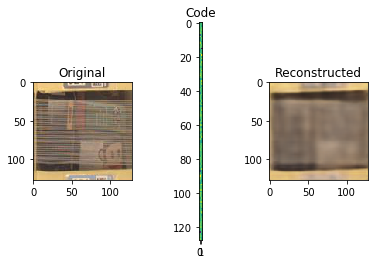

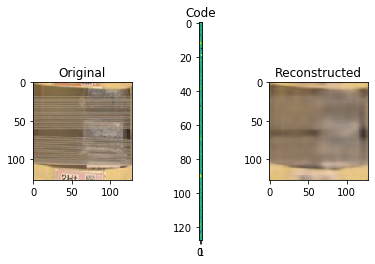

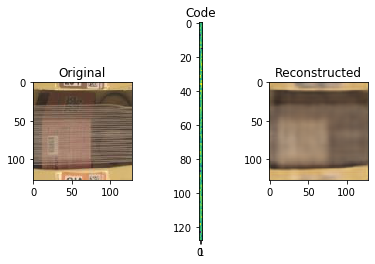

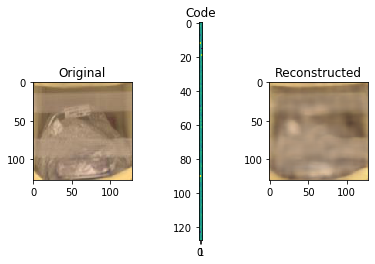

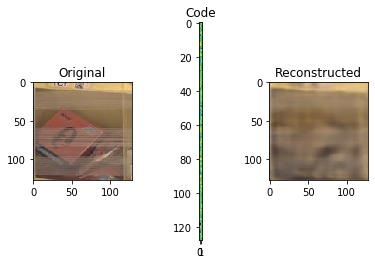

In [46]:
for i in range(0,5):
        img = frame.Xf_test[i]
        utils.visualize(img,frame.encoder,frame.decoder)

### load Denoise Dataset

In [47]:
frame.load_and_condition_dataset_denoise('../data/x_images_v2/', '../data/y_images_v2/')

### load the saved reconstruction autoencoder

In [17]:
frame.autoencoder = tf.keras.models.load_model("../model/autoencoder_reco.h5")
frame.encoder = tf.keras.models.load_model("../model/encoder_reco.h5")
frame.decoder = tf.keras.models.load_model("../model/decoder_reco.h5")

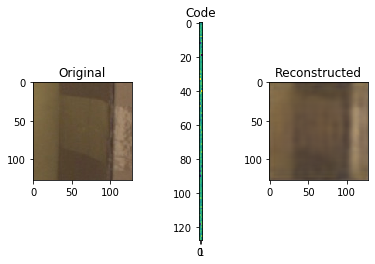

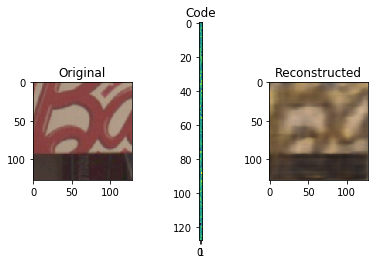

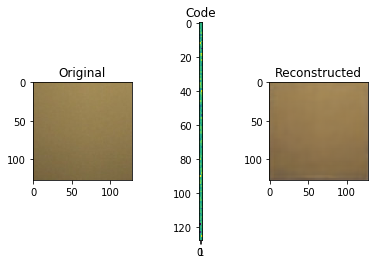

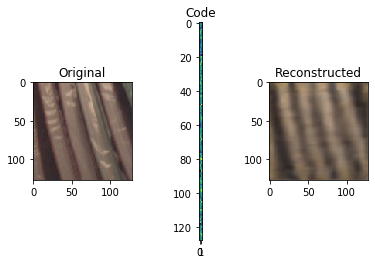

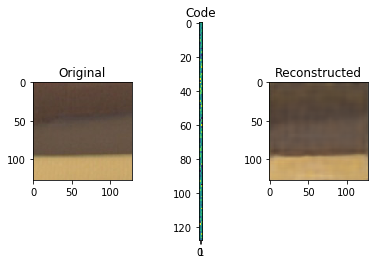

In [50]:
for i in range(5):
        img = frame.y_train[i]
        utils.visualize(img, frame.encoder,frame.decoder)

### Retrain with Denoise Dataset, but freeze the encoder.

In [51]:
frame.autoencoder.reset_metrics()
frame.encoder.trainable = False
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=False,
    name='Adam'
)
frame.autoencoder.compile(loss='mse', optimizer=optimizer, sample_weight_mode="temporal")
log_dir="../logs/denoise/train/" + dt.datetime.now().strftime("%Y%m%d-%H%M%S")
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=0.001)
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)
history = frame.autoencoder.fit(x=frame.X_train,
                y=frame.y_train,
                epochs=15,
                validation_split=0.1,
                batch_size=32, #keep batch in small
                callbacks = [tensorboard],
                use_multiprocessing=False
)

Train on 7217 samples, validate on 802 samples
Epoch 1/15
7217/7217 [==============================] - 10s 1ms/sample - loss: 0.0026 - val_loss: 0.0020
Epoch 2/15
7217/7217 [==============================] - 9s 1ms/sample - loss: 0.0017 - val_loss: 0.0016
Epoch 3/15
7217/7217 [==============================] - 9s 1ms/sample - loss: 0.0014 - val_loss: 0.0014
Epoch 4/15
7217/7217 [==============================] - 9s 1ms/sample - loss: 0.0012 - val_loss: 0.0012
Epoch 5/15
7217/7217 [==============================] - 9s 1ms/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 6/15
7217/7217 [==============================] - 9s 1ms/sample - loss: 0.0011 - val_loss: 0.0011
Epoch 7/15
7217/7217 [==============================] - 9s 1ms/sample - loss: 0.0010 - val_loss: 0.0011
Epoch 8/15
7217/7217 [==============================] - 9s 1ms/sample - loss: 9.4555e-04 - val_loss: 9.8604e-04
Epoch 9/15
7217/7217 [==============================] - 9s 1ms/sample - loss: 8.9993e-04 - val_loss: 9.6275e-04


In [52]:
log_dir="../logs/denoise/train/" + dt.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)    
frame.autoencoder.evaluate(x=frame.X_test, 
                        y=frame.y_test, 
                        batch_size=frame.batch_size, 
                        verbose=2, 
                        callbacks=[tensorboard], 
                        #max_queue_size=10, 
                        #workers=1, 
                        use_multiprocessing=False
)

891/891 - 1s - loss: 8.3209e-04


0.0008320927883991731

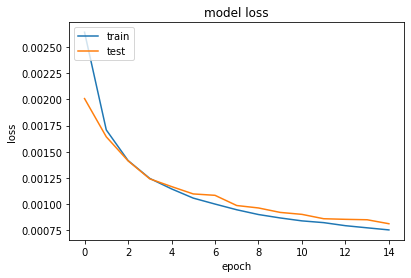

In [54]:
utils.plot_history(history)

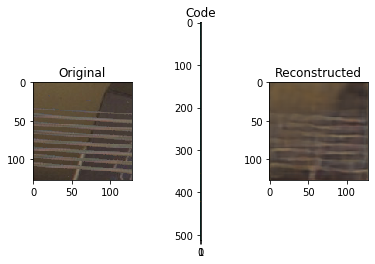

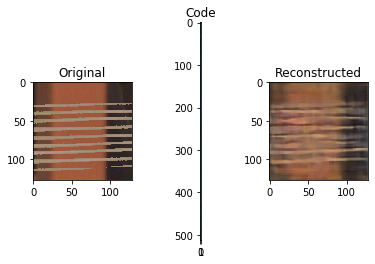

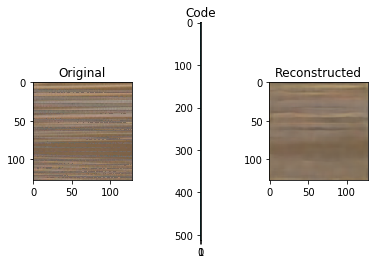

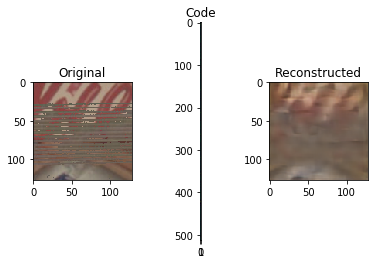

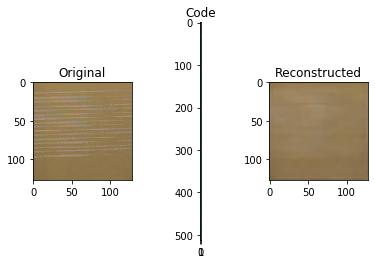

In [22]:
for i in range(5):
        img = frame.X_test[i]
        fr.visualize(img, frame.encoder,frame.decoder)

In [ ]:
frame.autoencoder.reset_metrics()
frame.autoencoder.save("../model/autoencoder_denoise.h5")
frame.encoder.save("../model/encoder_denoise.h5")
frame.decoder.save("../model/decoder_denoise.h5")

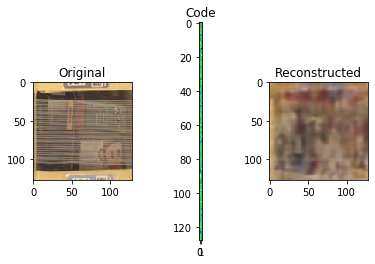

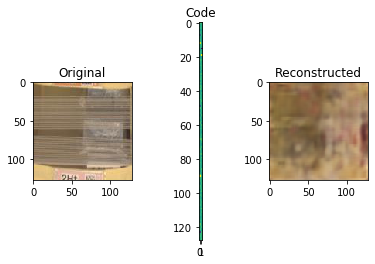

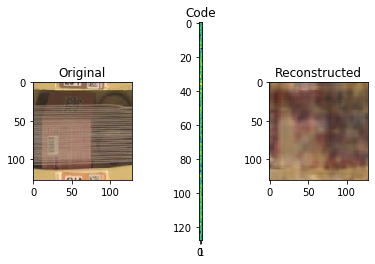

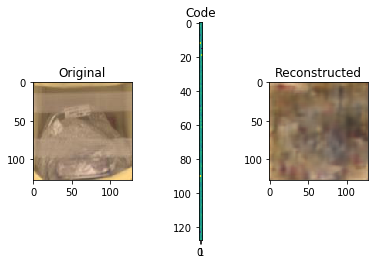

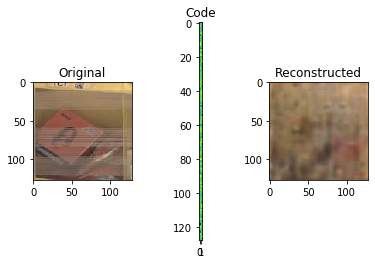

In [56]:
for i in range(5):
        img = frame.Xf_test[i]
        utils.visualize(img,frame.encoder,frame.decoder)

## Prediction Model Count up to 5.

In [61]:
# # load the saved model
# frame.autoencoder = tf.keras.models.load_model("../model/autoencoder_reco")
# frame.encoder = tf.keras.models.load_model("../model/encoder_reco")
# frame.decoder = tf.keras.models.load_model("../model/decoder_reco")

In [57]:
# load dataset
X_train, X_test, y_train, y_test = ds0.load_data()

get_metadata: Available Images: 29312


In [58]:
# categorize the integer label(# of objects)
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [111]:
# Prepare Datasets
frame.batch_size = 256
frame.load_datagenerators(X_train, y_train, X_test, y_test, input_size = (128, 128))
frame.input_shape = (128, 128, 3)

In [135]:
# if we tretrain with other parameter, reset the datagen
frame.train_generator.reset()
frame.valid_generator.reset()
frame.test_generator.reset()

In [136]:
def build_decoder_predict(frame):

    latent_inputs = Input(shape=(frame.latent_dim,), name='decoder_input')
    x = Dense(frame.latent_dim, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(latent_inputs)
    x = Dropout(0.5)(x)
    x = Dense(frame.latent_dim, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Dropout(0.5)(x)
    outputs = Dense(6, activation='softmax')(x)
    frame.decoder = Model(latent_inputs, outputs, name='decoder_predicter')

In [137]:
def build_model_predict(frame):
    frame.model_predict = Model(frame.inputs, frame.decoder(frame.encoder(frame.inputs)), name='model_predict')
    optimizer = optimizers.Adam(
        learning_rate=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
        name='Adam'
    )
    frame.model_predict.compile(loss='categorical_crossentropy',
                    optimizer=optimizer,
                    metrics=['accuracy', utils.soft_rmse])

In [138]:
# load models
frame.inputs = frame.encoder.input
frame.load_decoder(build_decoder_predict)
frame.load_model_predict(build_model_predict)

In [139]:
frame.model_predict.summary()

Model: "model_predict"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 128, 128, 3)]     0         
_________________________________________________________________
encoder (Model)              (None, 256)               527224    
_________________________________________________________________
decoder_predicter (Model)    (None, 6)                 198918    
Total params: 726,142
Trainable params: 198,918
Non-trainable params: 527,224
_________________________________________________________________


In [140]:
frame.decoder.summary()

Model: "decoder_predicter"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 256)]             0         
_________________________________________________________________
dense_24 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_16 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_17 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_18 (Dropout)         (None, 256)         

In [141]:
utils.print_model_properties(frame.encoder)

Layer 0 | Name: encoder_input | Trainable: False
Layer 1 | Name: conv2d | Trainable: False
Layer 2 | Name: batch_normalization | Trainable: False
Layer 3 | Name: tf_op_layer_Relu | Trainable: False
Layer 4 | Name: max_pooling2d | Trainable: False
Layer 5 | Name: conv2d_1 | Trainable: False
Layer 6 | Name: batch_normalization_1 | Trainable: False
Layer 7 | Name: tf_op_layer_Relu_1 | Trainable: False
Layer 8 | Name: max_pooling2d_1 | Trainable: False
Layer 9 | Name: conv2d_2 | Trainable: False
Layer 10 | Name: batch_normalization_2 | Trainable: False
Layer 11 | Name: tf_op_layer_Relu_2 | Trainable: False
Layer 12 | Name: max_pooling2d_2 | Trainable: False
Layer 13 | Name: flatten | Trainable: False
Layer 14 | Name: latent_vector | Trainable: False


In [142]:
utils.print_model_properties(frame.decoder)

Layer 0 | Name: decoder_input | Trainable: True
Layer 1 | Name: dense_24 | Trainable: True
Layer 2 | Name: dropout_16 | Trainable: True
Layer 3 | Name: dense_25 | Trainable: True
Layer 4 | Name: dropout_17 | Trainable: True
Layer 5 | Name: dense_26 | Trainable: True
Layer 6 | Name: dropout_18 | Trainable: True
Layer 7 | Name: dense_27 | Trainable: True


In [143]:
utils.print_model_properties(frame.model_predict)

Layer 0 | Name: encoder_input | Trainable: False
Layer 1 | Name: encoder | Trainable: False
Layer 2 | Name: decoder_predicter | Trainable: True


In [ ]:
# set trainable layer to top layers only
#fr.change_trainable_layers(frame.encoder, 9)
#frame.encoder.trainable = False

In [144]:
# Fit model
log_dir="../logs/prediction/train/" + dt.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
history = frame.model_predict.fit(
        x=frame.train_generator,
        #y=self.train_df['label'].values,
        #generator = train_generator,
        batch_size=None,
        epochs=40,
        verbose=1,
        validation_data=frame.valid_generator,
        #shuffle=False,
        #class_weight=None,
        #sample_weight=None,
        #initial_epoch=0,
        steps_per_epoch=frame.STEP_SIZE_TRAIN,
        validation_steps=frame.STEP_SIZE_VALID,
        #validation_freq=1,
        max_queue_size=frame.batch_size*8,
        #workers=4,
        use_multiprocessing=False,
        callbacks=[tensorboard_callback]
    )

Train for 73 steps, validate for 18 steps
Epoch 1/40
73/73 [==============================] - 11s 152ms/step - loss: 2.3909 - accuracy: 0.2332 - soft_rmse: 1.9754 - val_loss: 2.1447 - val_accuracy: 0.3084 - val_soft_rmse: 1.9652
Epoch 2/40
73/73 [==============================] - 9s 126ms/step - loss: 2.0727 - accuracy: 0.3171 - soft_rmse: 1.6740 - val_loss: 1.9291 - val_accuracy: 0.3550 - val_soft_rmse: 1.5824
Epoch 3/40
73/73 [==============================] - 9s 126ms/step - loss: 1.9095 - accuracy: 0.3461 - soft_rmse: 1.5836 - val_loss: 1.7955 - val_accuracy: 0.3687 - val_soft_rmse: 1.4214
Epoch 4/40
73/73 [==============================] - 10s 140ms/step - loss: 1.7907 - accuracy: 0.3541 - soft_rmse: 1.5455 - val_loss: 1.7057 - val_accuracy: 0.3865 - val_soft_rmse: 1.5682
Epoch 5/40
73/73 [==============================] - 8s 116ms/step - loss: 1.7107 - accuracy: 0.3634 - soft_rmse: 1.5215 - val_loss: 1.6437 - val_accuracy: 0.3787 - val_soft_rmse: 1.4737
Epoch 6/40
73/73 [========

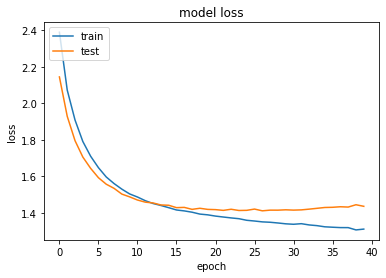

In [146]:
utils.plot_history(history)

In [147]:
print('\nValidationg the model ... ...')
log_dir="../logs/prediction/validation/" + dt.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
frame.model_predict.evaluate(
        x=frame.test_generator,
        y=None,
        batch_size=None,
        verbose=1,
        sample_weight=None,
        steps=frame.STEP_SIZE_TEST,
        max_queue_size=frame.batch_size*8,
        #workers=1,
        use_multiprocessing=False,
        callbacks=[tensorboard_callback]
    )


Validationg the model ... ...
22/22 [==============================] - 2s 84ms/step - loss: 1.4237 - accuracy: 0.4038 - soft_rmse: 1.4521


[1.4237261793830178, 0.40376422, 1.4521257]

In [162]:
pred = frame.model_predict.predict(x=frame.test_generator,
            steps=frame.STEP_SIZE_TEST + 1,
            max_queue_size=frame.batch_size*8,
            #workers=8,
            use_multiprocessing=False,
            verbose=True)

23/23 [==============================] - 2s 97ms/step


In [82]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

def plot_metrics(rmse, acc):
    fig, ax1 = plt.subplots()
    x = np.arange(1, len(rmse)+1, 1)
    y1 = rmse
    ax1.plot(x, y1, 'b-')
    ax1.set_xlabel('Epoch')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel('RMSE', color='b')
    ax1.tick_params('y', colors='b')

    ax2 = ax1.twinx()
    y2 = acc
    ax2.plot(x, y2, 'r-')
    ax2.set_ylabel('Accuracy', color='r')
    ax2.tick_params('y', colors='r')

    fig.tight_layout()
    #fig.savefig('../image/loss_vs_acc.png')
    plt.show()
    pass

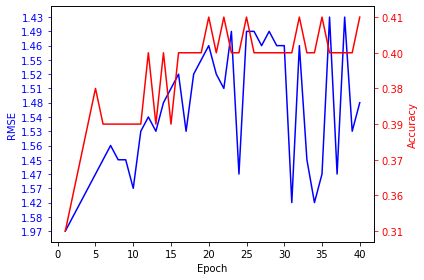

In [148]:
# load the pickled history files
val_acc = ['%.2f' % elem for elem in history.history.get('val_accuracy')]
val_rmse = ['%.2f' % elem for elem in history.history.get('val_soft_rmse')]
train_acc = ['%.2f' % elem for elem in history.history.get('accuracy')]
train_loss = ['%.2f' % elem for elem in history.history.get('soft_rmse')]
plot_metrics(val_rmse, val_acc)

In [164]:
y_hat = np.argmax(pred, axis=1)

In [165]:
y_true = np.argmax(y_test, axis=1)

In [168]:
#double check metrics Accuracy
utils.soft_acc(y_true, y_hat)

<tf.Tensor: id=212949, shape=(), dtype=float32, numpy=0.40269488>

In [176]:
#double check metrics Root Mean Square Error
np.sqrt(np.mean((y_true - y_hat)**2))

1.4545241342459299

In [177]:
#save prediction model
frame.model_predict.save("../model/model_predict.h5")

In [178]:
from tensorflow.keras.callbacks import TensorBoard

In [179]:
!tensorboard --logdir '/home/ubuntu/amzbinimg/logs'

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.0.1 at http://localhost:6006/ (Press CTRL+C to quit)
W0305 07:09:57.129360 139939580032768 plugin_event_accumulator.py:294] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
^C


In [8]:
def build_encoder(frame):
    inputs = Input(shape=frame.input_shape, name='encoder_input')
    x = inputs

    x = Conv2D(filters=8, kernel_size=frame.kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization(trainable=False)(x)
    x = relu(x)
    x = MaxPooling2D(pool_size = (2, 2), padding='same')(x)

    x = Conv2D(filters=16, kernel_size=frame.kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization(trainable=False)(x)
    x = relu(x)
    x = MaxPooling2D(pool_size = (2, 2), padding='same')(x)

    x = Conv2D(filters=8, kernel_size=frame.kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization(trainable=False)(x)
    x = relu(x)
    x = MaxPooling2D(pool_size = (2, 2), padding='same')(x)

    
    # Shape info needed to build Decoder Model
    frame.shape = K.int_shape(x)
    # Generate the latent vector
    x = Flatten()(x)
    latent = Dense(frame.latent_dim, name='latent_vector')(x)

    # Instantiate Encoder Model
    frame.encoder = Model(inputs, latent, name='encoder')
    frame.inputs = inputs

In [9]:
def build_decoder(frame):

    latent_inputs = Input(shape=(frame.latent_dim,), name='decoder_input')
    x = Dense(frame.shape[1] * frame.shape[2] * frame.shape[3])(latent_inputs)
    x = Reshape((frame.shape[1], frame.shape[2], frame.shape[3]))(x)


    x = Conv2DTranspose(filters=8, kernel_size=frame.kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization(trainable=False)(x)
    x = relu(x)
    x = UpSampling2D((2, 2))(x)

    x = Conv2DTranspose(filters=16, kernel_size=frame.kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization(trainable=False)(x)
    x = relu(x)
    x = UpSampling2D((2, 2))(x)

    x = Conv2DTranspose(filters=8, kernel_size=frame.kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization(trainable=False)(x)
    x = relu(x)
    x = UpSampling2D((2, 2))(x)

    x = Conv2DTranspose(filters=3, kernel_size=frame.kernel_size, padding='same')(x)

    outputs = Activation('sigmoid', name='decoder_output')(x)

    # Instantiate Decoder Model
    frame.decoder = Model(latent_inputs, outputs, name='decoder')

In [10]:
def build_autoencoder(frame):
    frame.autoencoder = Model(frame.inputs, frame.decoder(frame.encoder(frame.inputs)), name='autoencoder')
    optimizer = tf.keras.optimizers.Adam(
                    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=False,
                    name='Adam'
                )
    frame.autoencoder.compile(loss='mse', optimizer=optimizer)